## Постановка задачи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.



### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Данные

[final_provider.zip](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/ac39c23b-718e-4cd6-bdaa-85b3a127a457/final_provider.zip)

Данные также находятся в тренажёре, в папке `/datasets/final_provider/`.

## Импорты


In [1]:
# !pip3 install --upgrade pandas

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

## Загрузка датасетов

In [3]:
#Константные переменные
BASE_DIR = '/datasets/final_provider/'
CONTRACTS = 'contract.csv'
INTERNET = 'internet.csv'
PERSONAL = 'personal.csv'
PHONE = 'phone.csv'

In [4]:
contracts_df = pd.read_csv(os.path.join(BASE_DIR, CONTRACTS))
internet_df = pd.read_csv(os.path.join(BASE_DIR, INTERNET))
personal_df = pd.read_csv(os.path.join(BASE_DIR, PERSONAL))
phone_df = pd.read_csv(os.path.join(BASE_DIR, PHONE))

# Первичный анализ и преобразование типов данных

## Contracts

Посмотрим на типы данных и заполненность датасета

In [5]:
contracts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пройдёмся по категориальным полям и сгруппируем онотипные значения, чтобы определить, сколько вообще видов значений есть

In [6]:
def get_obj_cols_values(df, start_сol_ind, end_col_ind):
    '''Считает value count по всем колонкам, указанным в промежутке 
    между индексами start_сol_ind и end_col_ind. Выводит график по каждой 
    колонке в промежутке'''
    try:
        print('Категориальные переменные датасета:')
        print()
        for col in df.columns[start_сol_ind:end_col_ind]:
            if df[col].dtype == 'object':
                print(col + ':')
                print()
                print(df[col].value_counts())
                sns.barplot(x=df[col].value_counts().index, y=df[col].value_counts())
                plt.xticks(rotation=45)
                plt.show()
                print()
    except:
        print('Проверь датасет и длину датасета')

Категориальные переменные датасета:

EndDate:

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64


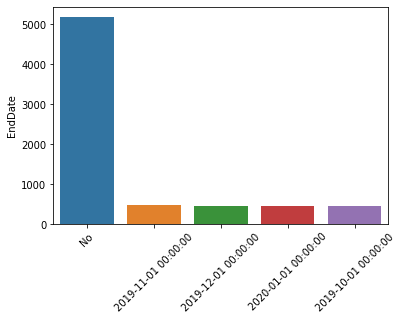


Type:

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64


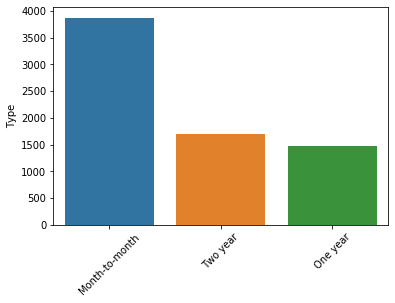


PaperlessBilling:

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64


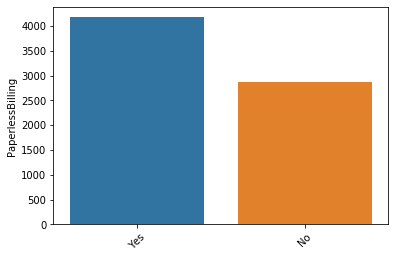


PaymentMethod:

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64


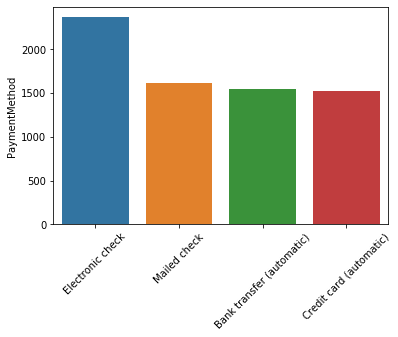

In [7]:
get_obj_cols_values(contracts_df, 2, 6)

Значения категориальных переменных распределены совершенно разным образом. 

`EndDate` по всем признакам должно быть с типом дата и время, но оно таковым не явлется. По всей видимости оно содержит строковые значения, из-за которых pandas инициализировал это поле как строковое. Проверим, какие ещё значения кроме дат есть в этом поле, кроме значения **No** (его мы заполним  датой 2020-02-01), для того, чтобы можно было сранивать `BeginDate` и `EndDate`. Заполнять `EndDate` мы будем только с целью расчёта скидок на клиенте, но никак для замены значений **No** датой 

Странно, но в `EndDate` не так много разновидностей значений. Если расценивать это поле, как целевую метку (т.е. в качестве признака, означающий отток клиента), то это ещё более странно, т.к. есть всего 4 даты из ~ 2к отказавшихся от услуг клиентов, что является явной сезонной особенностью. А что ещё более странно, т.к. это 4 последовательных месяца с октября 2020 по январь 2021 (стоит явно подчеркнуть заказчику работы) с равным кол-вом отказов

Прежде чем дозаполнить **No** значения и превратить `EndDate` в поле с типом дата, сделаем из его копии целевой признак. Но инвертируем логику, сделав негативный класс 1, а позитивный 0, чтобы модель училась предсказывать именно 1, т.е. положительный класс.

In [8]:
#заполняет новое поле значением 0, если в EndDate No, иначе 1
contracts_df['Label'] = np.where(contracts_df['EndDate'] == 'No', 0, 1)

In [9]:
#заменяет No на 2020-02-01 (текущий месяц по условиям задачи)
contracts_df['EndDateFormated'] = contracts_df['EndDate'].copy()
contracts_df['EndDateFormated'] = contracts_df['EndDateFormated'].where(
    contracts_df['EndDateFormated']!='No', 
    '2020-02-01'
)
#переводит в тип даты и времени
contracts_df['EndDateFormated'] = pd.to_datetime(contracts_df['EndDateFormated'])

Теперь поймём, почему тип данных у `TotalCharges` строка, а не float. А затем преобразуем его к правильному типу данных

In [10]:
contracts_df['TotalCharges'].sort_values().head()

936      
3826     
4380     
753      
5218     
Name: TotalCharges, dtype: object

Судя по всему поле содержит пустые значения в виде пробелов или других непечатаемых символов. Чтобы преобразовать поле в правильный тип данных нужно заменить такие значения на что-то более подходящее для преобразования

Нам пригодится `BeginDate` в виде индекса с типом датам и время, чтобы можно было удобно с ним работать. Приведём поле к нужному типу данных и поставим его в индекс датасета

In [11]:
#установка нового индекса
contracts_df.set_index(
    pd.to_datetime(contracts_df['BeginDate']),
    inplace=True
)

#удаление ненужной колонки
contracts_df.drop('BeginDate', inplace=True, axis=1)

In [12]:
contracts_df.loc[
    contracts_df['TotalCharges'].str.contains(contracts_df.loc['2020-02-01', 'TotalCharges'][0])
].head(15)

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Label,EndDateFormated
BeginDate,,,,,,,,,
2020-02-01,4472-LVYGI,No,Two year,Yes,Bank transfer (automatic),52.55,,0,2020-02-01
2020-02-01,3115-CZMZD,No,Two year,No,Mailed check,20.25,,0,2020-02-01
2020-02-01,5709-LVOEQ,No,Two year,No,Mailed check,80.85,,0,2020-02-01
2020-02-01,4367-NUYAO,No,Two year,No,Mailed check,25.75,,0,2020-02-01
2020-02-01,1371-DWPAZ,No,Two year,No,Credit card (automatic),56.05,,0,2020-02-01
2020-02-01,7644-OMVMY,No,Two year,No,Mailed check,19.85,,0,2020-02-01
2020-02-01,3213-VVOLG,No,Two year,No,Mailed check,25.35,,0,2020-02-01
2020-02-01,2520-SGTTA,No,Two year,No,Mailed check,20.00,,0,2020-02-01
2020-02-01,2923-ARZLG,No,One year,Yes,Mailed check,19.70,,0,2020-02-01


Судя по таблице выше пустые `TotalCharges` это клиенты, подключившиеся к услугам в текущем месяце. Отсуствие `TotalCharges` можно оправдать тем, что скорее всего оно рассчитывается для клиентов оплачивающих услуги более одного месяца. Заполним эти пропуски значением `MonthlyCharges` строки, т.к. это не противоречит логики и бизнесу, зато поможет нам преобразовать поел к нужному типу данных

In [13]:
#заполняем пропуски TotalCharges значением MonthlyCharges
contracts_df.loc[
    contracts_df['TotalCharges'].str.contains(contracts_df.loc['2020-02-01', 'TotalCharges'][0]),
    'TotalCharges'
] = contracts_df.loc[
    contracts_df['TotalCharges'].str.contains(contracts_df.loc['2020-02-01', 'TotalCharges'][0]), 
    'MonthlyCharges'
]

In [14]:
#приведём TotalCharges к числу с плавающей точкой
contracts_df['TotalCharges'] = contracts_df['TotalCharges'].astype('float')

Проверим полные дубликаты и дубликаты среди `customerID`

In [15]:
def print_duplicates(df, col_list=['customerID']):
    try:
        for col in col_list:
            print('Кол-во дубликатов customerID: {}'.format(df[col].duplicated().sum()))
            print('Кол-во полных дублей: {}'.format(df.duplicated().sum()))
    except:
        print('Проверь датасет и название колонки')

In [16]:
print_duplicates(contracts_df)

Кол-во дубликатов customerID: 0
Кол-во полных дублей: 0


Настал черёд разобраться с `PaperlessBilling` не смотря на то, что поле имеет исходно строковый формат, преобразуем его для удобства в бинарное представление, где Yes приравняем к 1, а No к 0

In [17]:
contracts_df['PaperlessBilling'] = np.where(contracts_df['PaperlessBilling'] == 'Yes', 1, 0)

Вычислим текущих клиентов, обладающих скидкой. Для этого:
1. Получим разницу в месяцах между `BeginDate` и `EndDate` (нулевые значения заменим на 1, чтобы произведение на след шае дало как минимум тот же результат, что и в `MonthlyCharges`)
2. Получим произведение разницы в месяцах (кол-во месяцев посчитаем самым простым способом – получим частное от деления нацело числа 30, на интервале до 5 лет это должно дать приблизительно правильные результат, т.к. круг на целый месяц не набежит ранее 5ти лет) на `MonthlyCharges`
3. Сравним полученный результат с `TotalCharges`
4. Несовпавшие значения объявим:
- если < скидками 
- если > аномалиями (либо что-то пошло не так и клиент платит меньше чем должен, либо дисконт начисляется на `TotalCharges`, либо клиент плати меньше чем он должен, если оплата производится по `MonthlyCharges`)

In [18]:
#получим дельту между датами в днях
contracts_df['EndBeginDelta'] = contracts_df['EndDateFormated'] - contracts_df.index
#получим кол-во месяцев в дельте
contracts_df['MonthInDelta'] = contracts_df['EndBeginDelta'].dt.days // 30
#получим произведение дельты на месячную плату
contracts_df['CalculatedTotalCharges'] = contracts_df['MonthInDelta'] * contracts_df['MonthlyCharges']

Займёмся кодированием признаков и подготовка первичного датасета для передачи в модель. Пока оставим только самые важные признаки, остальные уберём и будем добавлять по мере необходимости, если модель не будет справляться. На первый взгляд кажется, что самые важные параметры это: `Type`, `PeperlessBilling`, `PaymentMethod`, `MonthlyCharges` (`TotalCharges` пока не добавляем, вероятно оно сильно коррелирует с месячными платежами), `MonthInDeltaz`, `EndBeginDelta`, а `customerID` нам нужен только для присоединения остальных датасетов

In [19]:
#создадим фрейм от копии
contracts_main_features_df = contracts_df[[
    'customerID', 'Type', 'PaperlessBilling', 'PaymentMethod',
    'MonthlyCharges',  'MonthInDelta', 'EndBeginDelta', 'Label', 'TotalCharges']].copy()
#сохраним дельту, как кол-во дней
contracts_main_features_df['EndBeginDelta'] = contracts_main_features_df['EndBeginDelta'].dt.days
#закодируем категориальные признаки ohe 
ohe_enc = OneHotEncoder()
contracts_cat_feature_ohe = ohe_enc.fit_transform(
    contracts_main_features_df[['PaymentMethod']]
).toarray()

#заполним фрейм ohe признаками
# contracts_main_features_df[
#     contracts_main_features_df['PaymentMethod'].unique()
# ] = contracts_cat_feature_ohe

#заполним фрейм ohe признаками
contracts_main_features_df[
    'Electronic check'
] = contracts_cat_feature_ohe[:, 0]

contracts_main_features_df[
   'Mailed check'
] = contracts_cat_feature_ohe[:, 1]

contracts_main_features_df[
    'Bank transfer (automatic)'
] = contracts_cat_feature_ohe[:, 2]

contracts_main_features_df[
    'Credit card (automatic)'
] = contracts_cat_feature_ohe[:, 3]


#удалим дублирующие поля
contracts_main_features_df.drop(['PaymentMethod'], axis=1, inplace=True)

In [20]:
#выделим нужные временные признаки из дата начала
contracts_main_features_df['BeginYear'] = contracts_main_features_df.index.year
contracts_main_features_df['BeginMonth'] = contracts_main_features_df.index.month

Не смотря на то, что `Type` свиду категориальный признак, мы привратим его в числовой признак. Где за Month-to-month возьмём 1 месяц, One year 12 месяцев и Two year 24 месяца. То же самое, но в обратной пропорции сделаем для года и двух лет

In [21]:
#добавим 3 новых поля и вычислим значения соотношением месяца к году и к двум годам и обратно
contracts_main_features_df['PayInterval'] = contracts_main_features_df['Type']
contracts_main_features_df['year'] = contracts_main_features_df['Type']
contracts_main_features_df['two_year'] = contracts_main_features_df['Type']

contracts_main_features_df['PayInterval'] = contracts_main_features_df['PayInterval'].apply(lambda x: 
                                                                              1 if x == 'Month-to-month' else (
                                                                              12 if x == 'One year' else 24)
                                                                             )

contracts_main_features_df['year'] = contracts_main_features_df['year'].apply(lambda x: 
                                                                              12 if x == 'Month-to-month' else (
                                                                              1 if x == 'One year' else 1/2)
                                                                             )

contracts_main_features_df['two_year'] = contracts_main_features_df['two_year'].apply(lambda x: 
                                                                              24 if x == 'Month-to-month' else (
                                                                              2 if x == 'One year' else 1)
                                                                             )

Как дополнительный признак можем подсчитать кол-во интервалов сколько клиент продержался с договором в соответствии с выбранным им периодом оплаты (месяц, год, два года)

In [22]:
def IntervalsInEndBeginDeltaByType(row):
    try:
        if row['Type'] == 'Month-to-month':
            return row['EndBeginDelta'] // 30
        elif row['Type'] == 'One year':
            return row['EndBeginDelta'] // 30 // 12
        else:
            return row['EndBeginDelta'] // 30 // (12 * 2)
    except:
        print('Датафрейм должен содержать Type 3-мя значениями')

In [23]:
contracts_main_features_df['IntervalsInEndBeginDeltaByType'] = contracts_main_features_df.apply(IntervalsInEndBeginDeltaByType, axis=1)
contracts_main_features_df.drop('Type', axis=1, inplace=True)

Напоследок взглянем на общие статистики датасета

In [24]:
contracts_main_features_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7043 entries, 2020-01-01 to 2014-08-01
Data columns (total 17 columns):
customerID                        7043 non-null object
PaperlessBilling                  7043 non-null int64
MonthlyCharges                    7043 non-null float64
MonthInDelta                      7043 non-null int64
EndBeginDelta                     7043 non-null int64
Label                             7043 non-null int64
TotalCharges                      7043 non-null float64
Electronic check                  7043 non-null float64
Mailed check                      7043 non-null float64
Bank transfer (automatic)         7043 non-null float64
Credit card (automatic)           7043 non-null float64
BeginYear                         7043 non-null int64
BeginMonth                        7043 non-null int64
PayInterval                       7043 non-null int64
year                              7043 non-null float64
two_year                          7043 non-null in

In [25]:
contracts_main_features_df.head()

,customerID,PaperlessBilling,MonthlyCharges,MonthInDelta,EndBeginDelta,Label,TotalCharges,Electronic check,Mailed check,Bank transfer (automatic),Credit card (automatic),BeginYear,BeginMonth,PayInterval,year,two_year,IntervalsInEndBeginDeltaByType
BeginDate,,,,,,,,,,,,,,,,,
2020-01-01,7590-VHVEG,1,29.85,1,31,0,29.85,0.0,0.0,1.0,0.0,2020,1,1,12.0,24,1
2017-04-01,5575-GNVDE,0,56.95,34,1036,0,1889.50,0.0,0.0,0.0,1.0,2017,4,12,1.0,2,2
2019-10-01,3668-QPYBK,1,53.85,2,61,1,108.15,0.0,0.0,0.0,1.0,2019,10,1,12.0,24,2
2016-05-01,7795-CFOCW,0,42.30,45,1371,0,1840.75,1.0,0.0,0.0,0.0,2016,5,12,1.0,2,3
2019-09-01,9237-HQITU,1,70.70,2,61,1,151.65,0.0,0.0,1.0,0.0,2019,9,1,12.0,24,2


### Выводы

1. Пропусков и дубликатов нет 
2. Данные преобразованы к корректным типам
3. Выделены дополнительные признаки, которые можно использовать в случае слабого качества модели

## Internet

In [26]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [27]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


Первое, что бросается в глаза, так это то, что клиентов гораздо меньше, чем контрактов. Согласно условия задачи это является показателем того, что все остальные клиенты в контрактах не пользуются интернетом

Категориальные переменные датасета:

InternetService:

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64


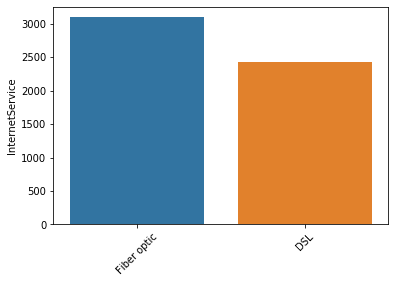


OnlineSecurity:

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64


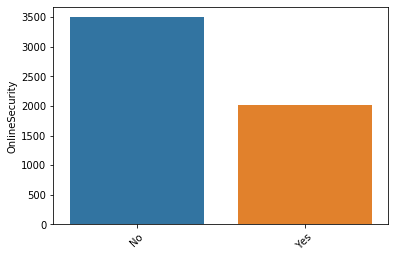


OnlineBackup:

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64


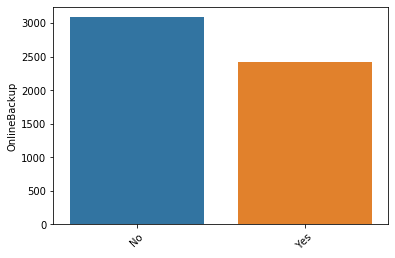


DeviceProtection:

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64


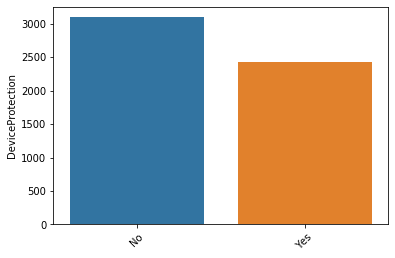


TechSupport:

No     3473
Yes    2044
Name: TechSupport, dtype: int64


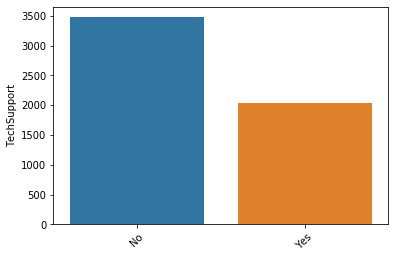


StreamingTV:

No     2810
Yes    2707
Name: StreamingTV, dtype: int64


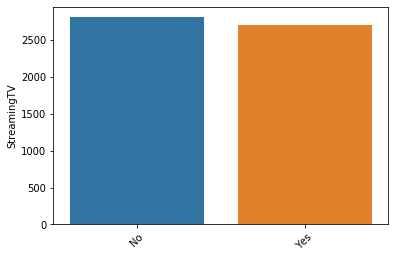


StreamingMovies:

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64


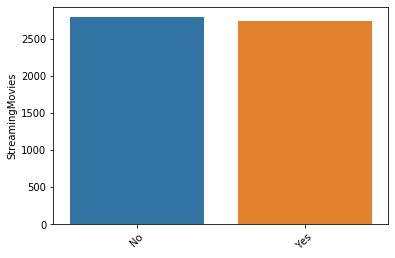

In [28]:
get_obj_cols_values(internet_df, 1, 10)

Преобразуем все строковые поля со значениями Yes, No в бинарный вид, чтобы модель могла с ними работать

In [29]:
#произведём замены
internet_df = internet_df.replace('Yes', 1).replace('No', 0)

In [30]:
active_clients_ids = contracts_df.loc[contracts_df['Label']==0, 'customerID']
not_active_clients_ids = contracts_df.loc[contracts_df['Label']==1, 'customerID']

print('Доля клиентов с интернетом: {:.2%}'.format(internet_df.shape[0] / contracts_df.shape[0]))

print('Доля действующих клиентов с интернетом: {:.2%}'.format(
    internet_df[internet_df['customerID'].isin(active_clients_ids)].shape[0] / active_clients_ids.shape[0])
     )

print('Доля рассторжников с интернетом: {:.2%}'.format(
    internet_df[internet_df['customerID'].isin(not_active_clients_ids)].shape[0] / active_clients_ids.shape[0])
     )

Доля клиентов с интернетом: 78.33%
Доля действующих клиентов с интернетом: 72.69%
Доля рассторжников с интернетом: 33.94%


На текущий момент не очень понятно будет ли данный датасет и его поля полезны модели для выявления зависимостей при оценке вероятности оттока клиентом, но мы на всякий случай подготовим данные для передачи в модель. Для того, чтобы это сделать, нам нужно уравнять формы датасетов (т.е. восполнить датасет с интернетом юзерами из контрактов, которых нет в данном датасете) и все признаки заполним нулевым значением. А чтобы модель могла различить реальных клиентов с интернетом от виртуальных добавленных нами добавим ещё один бинарный признак, где 1 будет выставлена для всех клиентов с интернетом, а виртуальным мы поставим 0, а в `InternetService` запишем Unknown

In [31]:
internet_df['is_active_internet'] = 1
#получим ид клиентов с интернетом
internet_clients_ids = internet_df['customerID']
#получим ид клиентов у которых нет интернета
without_inernet_clients_ids = contracts_df.loc[
    ~contracts_df['customerID'].isin(internet_clients_ids), 
    'customerID'
]
#сгенерим матрицу для заполнения данными виртуальных клиентов
virtual_data = np.zeros((without_inernet_clients_ids.shape[0], 
                         internet_df.shape[1] - 1
                        ),dtype='int')
#создадим датафрейм
virtual_clients_df = pd.DataFrame(without_inernet_clients_ids, columns=internet_df.columns)
#заполним датафрейм
virtual_clients_df.iloc[:, 1:] = virtual_data
#объединим датафреймы
internet_concatenated_df = pd.concat([internet_df, virtual_clients_df], axis=0, ignore_index=True)
#заполним неизвестным значением нулевую колонку 
internet_concatenated_df.loc[
    internet_concatenated_df['InternetService'] == 0,
    'InternetService'
] = 'Unknown'

In [32]:
internet_concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
customerID            7043 non-null object
InternetService       7043 non-null object
OnlineSecurity        7043 non-null object
OnlineBackup          7043 non-null object
DeviceProtection      7043 non-null object
TechSupport           7043 non-null object
StreamingTV           7043 non-null object
StreamingMovies       7043 non-null object
is_active_internet    7043 non-null object
dtypes: object(9)
memory usage: 495.3+ KB


В результате мы получили равные по кол-ву клиентов датасет и можем использовать его в качестве признаков, при необходимости

In [33]:
print_duplicates(internet_concatenated_df)

Кол-во дубликатов customerID: 0
Кол-во полных дублей: 0


Осталось разобраться с `InternetService`. Методом One hot encoding преобразуем значения полей в колонки. Ordinal encoding не используем, потому что модели применяя арифметические операции будут считать, что значение большего порядка важнее, чем меньшего, да и значений у нас всего 3, поэтому ohe подойдёт

In [34]:
ohe_enc = OneHotEncoder()

#обучим энкодер и преобразуем поле в матрицу 
ohe_service_features = ohe_enc.fit_transform(
    internet_concatenated_df[['InternetService']]
).toarray()

#присоединим данные к старому фрейму
internet_concatenated_df['Fiber optic'] = ohe_service_features[:,0]
internet_concatenated_df['DSL'] = ohe_service_features[:,1]
internet_concatenated_df['Unknown'] = ohe_service_features[:,2]

#удалим лишнюю колонку 
internet_concatenated_df.drop('InternetService', axis=1, inplace=True)

In [35]:
for col in internet_concatenated_df.columns[1:]:
    internet_concatenated_df[col] = internet_concatenated_df[col].astype('float')

In [36]:
internet_concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
customerID            7043 non-null object
OnlineSecurity        7043 non-null float64
OnlineBackup          7043 non-null float64
DeviceProtection      7043 non-null float64
TechSupport           7043 non-null float64
StreamingTV           7043 non-null float64
StreamingMovies       7043 non-null float64
is_active_internet    7043 non-null float64
Fiber optic           7043 non-null float64
DSL                   7043 non-null float64
Unknown               7043 non-null float64
dtypes: float64(10), object(1)
memory usage: 605.4+ KB


### Выводы

1. В исходном датасете были пропуски, на текущий момент они устранены методом дополнения дельты клиентов из контрактов и добавления доп. признака
2. Дубликатов нет
3. Признаки приведены к корректному типу данных
4. Категориальные признаки преобразованы методом кодирования одного горячего состояния в бинарные колонки
5. При неободимости расширения признаков датасет готов к присоединению через `customerID`. Но полезность присоединения пока под вопросом

## Personal

Датасет содержит описание персональной информации клиента

In [37]:
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [38]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


На первый взгляд, судя по кол-ву клиентов, датасет описывает всех клиентов, присуствующих в контрактах. Удостоверимся, что в датасете нет лишних клиентов или тех, кого нет в контрактах

In [39]:
personal_clients_ids = personal_df['customerID']
print('Кол-во совпадающих ид: {}'.format(
    contracts_df[contracts_df['customerID'].isin(personal_clients_ids)].shape[0])
     )

Кол-во совпадающих ид: 7043


Отлично, контракты и клиенты содержат одних и тех же клиентов. Посмотрим на категориальные признаки датасета и их содержание

Категориальные переменные датасета:

gender:

Male      3555
Female    3488
Name: gender, dtype: int64


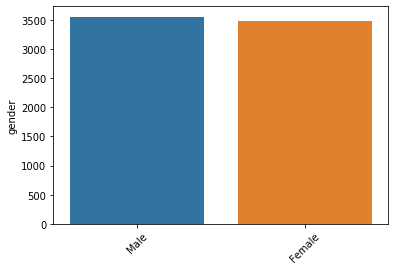


Partner:

No     3641
Yes    3402
Name: Partner, dtype: int64


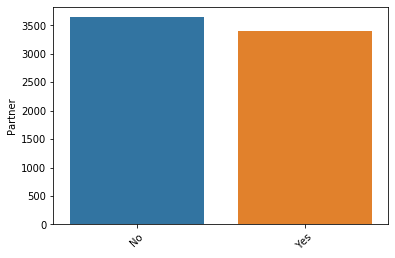


Dependents:

No     4933
Yes    2110
Name: Dependents, dtype: int64


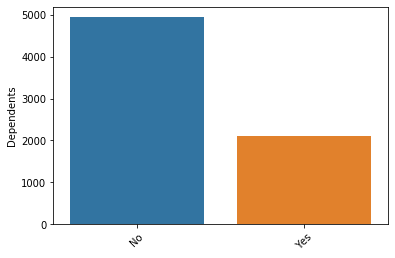

In [40]:
get_obj_cols_values(personal_df, 1, 10)

По половому признаку и партнёрам у нас почти равное соотношение, и преобладают (в два раза) клиенты по отсутствию иждевенцев. Ну и посмотрим на кол-во пенсионеров. 

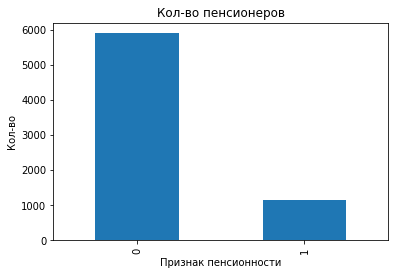

In [41]:
personal_df['SeniorCitizen'].value_counts().plot(kind='bar')
plt.title('Кол-во пенсионеров')
plt.xlabel('Признак пенсионности')
plt.ylabel('Кол-во');

Пенсионеров в разы меньше, чем непенсионеров

In [42]:
print_duplicates(personal_df)

Кол-во дубликатов customerID: 0
Кол-во полных дублей: 0


In [43]:
#преобразуем признаки к бинарному виду
personal_df = personal_df.replace('Yes', 1).replace('No', 0)

In [44]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null int64
Dependents       7043 non-null int64
dtypes: int64(3), object(2)
memory usage: 275.2+ KB


In [45]:
ohe = OneHotEncoder()
genders_ohe = ohe.fit_transform(personal_df[['gender']]).toarray()
genders_ohe_df = pd.DataFrame(genders_ohe, columns=personal_df['gender'].unique())
personal_df = pd.concat([personal_df, genders_ohe_df], axis=1, ignore_index=True)

In [46]:
personal_df.drop(1, axis=1, inplace=True)

In [47]:
for col in personal_df.columns[1:]:
    personal_df[col] = personal_df[col].astype('float')

In [48]:
#переназовём столбцы в человеческий вид
personal_df.columns =[
    'customerID', 'SeniorCitizen', 'Partner', 'Dependents', ohe.categories_[0][0], ohe.categories_[0][1]
]

In [49]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 6 columns):
customerID       7043 non-null object
SeniorCitizen    7043 non-null float64
Partner          7043 non-null float64
Dependents       7043 non-null float64
Female           7043 non-null float64
Male             7043 non-null float64
dtypes: float64(5), object(1)
memory usage: 330.3+ KB


### Выводы

1. Пропусков и дубликатов нет 
2. Датасет содержит описание всех клиентов из контрактов
3. Полезность датасета и его признаков для текуще задачи под сильным вопросом. Есть ощущение, что для прогноза вероятности оттока около персональные данные не особо имеют значения для данной конкретной задачи телеком оператора (к слову в банке напротив это должно иметь огромное значение). На этапе исследовательского анализа определим есть ли какие-то зависимости рассторжения от персональных характеристик клиента
4. Признаки приведены к корректному типу данных

## Phone

In [50]:
phone_df.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [51]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


Категориальные переменные датасета:

MultipleLines:

No     3390
Yes    2971
Name: MultipleLines, dtype: int64


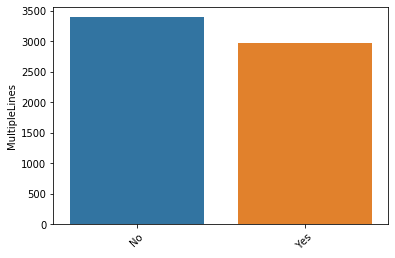

In [52]:
get_obj_cols_values(phone_df, 1, 10)

У нас почти равное кол-во клиентов, пользующихся обоими типами канальности. 

Преобразуем `MultipleLines` к бинарному виду, чтобы можно было передавать этот датасет в модель

In [53]:
phone_df['MultipleLines'] = np.where(phone_df['MultipleLines'] == 'Yes', 1, 0)

Судя по кол-ву записей в датасете клиентов в нём гораздо меньше, чем всего клиентов в контрактах. Это значит, что не все клиенты компанией пользуются услугой телефонии. Посчитаем долю клиентов, пользующихся данной услугой по отношению к общему кол-ву клиентов, а также доли клиентов расторгнувших договор и с действующим договором

In [54]:
print('Доля клиентов с телефонией: {:.2%}'.format(phone_df.shape[0] / contracts_df.shape[0]))

print('Доля действующих клиентов с телефонией: {:.2%}'.format(
    phone_df[phone_df['customerID'].isin(active_clients_ids)].shape[0] / active_clients_ids.shape[0])
     )

print('Доля рассторжников с телефонией: {:.2%}'.format(
    phone_df[phone_df['customerID'].isin(not_active_clients_ids)].shape[0] / active_clients_ids.shape[0])
     )

Доля клиентов с телефонией: 90.32%
Доля действующих клиентов с телефонией: 90.10%
Доля рассторжников с телефонией: 32.84%


Поступим с склиентами телефонии также, как с клиентами интернета. Донаполним датасет недостающим клиентами и заполним значения нулями, а чтобы модель могла различить реальных клиентов от виртуальных добавим дополнительную колонку в бинарном виде

In [55]:
phone_df['is_active_phone'] = 1
#получим ид клиентов с телефонией
phone_clients_ids = phone_df['customerID']
#получим ид клиентов у которых нет телефонии
without_phone_clients_ids = contracts_df.loc[
    ~contracts_df['customerID'].isin(phone_clients_ids), 
    'customerID'
]
#сгенерим матрицу для заполнения данными виртуальных клиентов
virtual_data = np.zeros((without_phone_clients_ids.shape[0], 
                         phone_df.shape[1] - 1
                        ), dtype='int')
#создадим датафрейм
virtual_clients_df = pd.DataFrame(without_phone_clients_ids, columns=phone_df.columns)
#заполним датафрейм
virtual_clients_df.iloc[:, 1:] = virtual_data
#объединим датафреймы
phone_concatenated_df = pd.concat([phone_df, virtual_clients_df], axis=0, ignore_index=True)

In [56]:
phone_concatenated_df['MultipleLines'] = phone_concatenated_df['MultipleLines'].astype('float')
phone_concatenated_df['is_active_phone'] = phone_concatenated_df['is_active_phone'].astype('float')

In [57]:
phone_concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 3 columns):
customerID         7043 non-null object
MultipleLines      7043 non-null float64
is_active_phone    7043 non-null float64
dtypes: float64(2), object(1)
memory usage: 165.2+ KB


В результате мы получили датасет телефонии с тем же кол-вом клиентов, что и в датасете контрактов

In [58]:
print_duplicates(phone_concatenated_df)

Кол-во дубликатов customerID: 0
Кол-во полных дублей: 0


### Выводы

1. В исходном датасете были пропуски, на текущий момент они устранены методом дополнения дельты клиентов из контрактов и добавления доп. признака
2. Дубликатов нет
3. Признаки приведены к корректному типу данных
4. При неободимости расширения признаков датасет готов к присоединению через `customerID`. Но полезность присоединения пока под вопросом

# Сборка базового датасета

Объединим датасеыты для проведения исследовательского анализа влияния перс данных, интернет и телефонии на контракты

In [59]:
#сбросим индексы
contracts_main_features_df.reset_index(drop=True, inplace=True)
internet_concatenated_df.reset_index(drop=True, inplace=True)
phone_concatenated_df.reset_index(drop=True, inplace=True)
personal_df.reset_index(drop=True, inplace=True)

In [60]:
#объединим все датасеты в один
merged_df = contracts_main_features_df.merge(internet_concatenated_df, on='customerID')
merged_df = merged_df.merge(phone_concatenated_df, on='customerID')
merged_df = merged_df.merge(personal_df, on='customerID')
merged_df.head()

,customerID,PaperlessBilling,MonthlyCharges,MonthInDelta,EndBeginDelta,Label,TotalCharges,Electronic check,Mailed check,Bank transfer (automatic),...,Fiber optic,DSL,Unknown,MultipleLines,is_active_phone,SeniorCitizen,Partner,Dependents,Female,Male
0,7590-VHVEG,1,29.85,1,31,0,29.85,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,5575-GNVDE,0,56.95,34,1036,0,1889.50,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,3668-QPYBK,1,53.85,2,61,1,108.15,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,7795-CFOCW,0,42.30,45,1371,0,1840.75,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,9237-HQITU,1,70.70,2,61,1,151.65,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Исследовательский анализ

## Contracts

In [61]:
def plot_dist(df, col):
    '''Рисует боксплот и график плотности распределения
    для заданного датасета и его одной колонки
    '''
    try:
        incline = 'влево' if df[col].median() > df[col].mean() else 'вправо'
        print(f'Скошенность распределения переменной: {incline}')
        _, axes = plt.subplots(1, 2, figsize=(16,3))

        sns.boxplot(data=df[col], orient='h', ax=axes[0])
        axes[0].set_xlabel(f'Размер {col}')
        axes[0].set_title(f'Боксплот {col}')

        sns.histplot(df[col], kde=True, ax=axes[1])
        axes[1].set_xlabel(f'Плотность распределения {col}')
        axes[1].set_ylabel('Кол-во')
        axes[1].set_title(f'Распределение {col}')
    
    except:
        print('Проверь тип данных колонки, должно быть целое или с плавающей точкой число')
        print(f'Тип данных переданной колонки: {df[col].dtype}');

Скошенность распределения переменной: влево
Проверь тип данных колонки, должно быть целое или с плавающей точкой число
Тип данных переданной колонки: float64


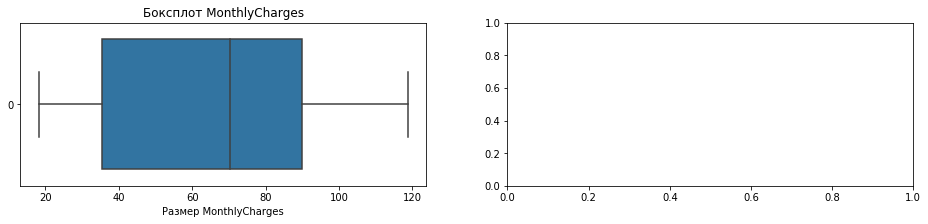

In [62]:
plot_dist(contracts_df, 'MonthlyCharges')

Распределение `MonthlyCharges` ассиметричное и скошено вправо. 50% значений лежит в пределах до 70, 75% значений до 90. Наиболее часто встречается значение с суммой менее 20 рублей. Выбросов нет.

Аналогичный анализ выполним и для `TotalCharges`.

Скошенность распределения переменной: вправо
Проверь тип данных колонки, должно быть целое или с плавающей точкой число
Тип данных переданной колонки: float64


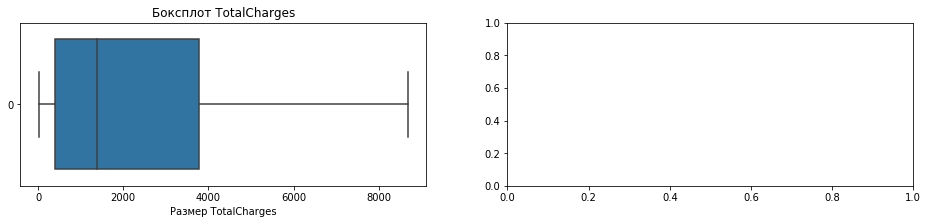

In [63]:
plot_dist(contracts_df, 'TotalCharges')

Распределение `TotalCharges` ассиметричное и скошено вправо. 50% значений лежит в пределах до 2000, 75% значений до 4000. Наиболее часто встречается значение с суммой менее 1000 рублей. Выбросов нет.

In [64]:
def compare_total_calculated(row):
    '''Сравнивает TotalCharges и рассчитанную CalculatedTotalCharges'''
    return '=' if row['CalculatedTotalCharges'] == row['TotalCharges'] \
            else ('<' if row['CalculatedTotalCharges'] < row['TotalCharges'] else '>')

In [65]:
#применим функцию сравнения тоталов
contracts_df['CheckDiscount'] = contracts_df.apply(compare_total_calculated, axis=1)

Категориальные переменные датасета:

CheckDiscount:

>    3486
<    2943
=     614
Name: CheckDiscount, dtype: int64


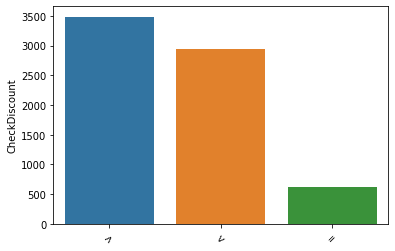

In [66]:
get_obj_cols_values(contracts_df, contracts_df.shape[1] - 1, 50)

Результаты неутишительные:
1. Преобладают примеры, для которых рассчитанный `CalculatedTotalCharges` больше иди меньше чем `TotalCharges` в исходном датасете. Хотя, это может быть результатом наличия доп. услуг и наличия скидок на клиенте. Например, все случаи, когда платит больше это допы, а когда меньше это скидки (сможем это проверить, когда присоединим остальные датасеты)
2. Равных примеров очень мало, даже в пропорции относительно двух других соотношений

Вопрос требует отдельного внимания со стороны владельца задачи

Получим разницу `CalculatedTotalCharges` и `TotalCharges` и посмотрим на распределение их дельты, для того, чтобы оценить на сколько в целом состоит разница

In [67]:
#получим дельту
contracts_df['CalculatedTotalChargesDelta'] = contracts_df['CalculatedTotalCharges'] - contracts_df['TotalCharges']

Скошенность распределения переменной: вправо
Проверь тип данных колонки, должно быть целое или с плавающей точкой число
Тип данных переданной колонки: float64


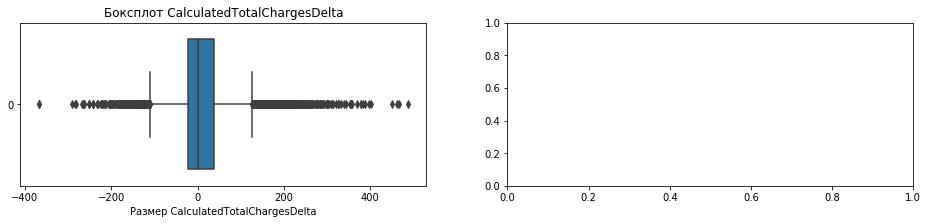

In [68]:
plot_dist(contracts_df, 'CalculatedTotalChargesDelta')

Несмотра на наличие явных выбросов с обеих сторон распределения, само по себе распределение в дельте нормальное. В центре распределеня те самые примеры, для которых дельта равну нулю, а по бокам либо скидка, либо аномалия

Также будет интересно посмотреть на распределение платежей в разрезе категориальных переменных

Среднее TotalCharges по способам оплаты и типу:


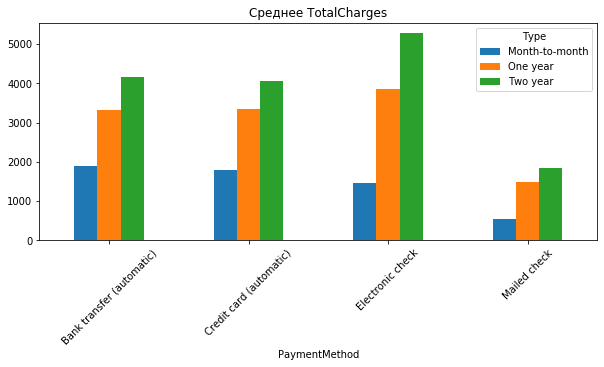

In [69]:
print('Среднее TotalCharges по способам оплаты и типу:')
contracts_df.pivot_table(
        index='PaymentMethod', columns='Type', 
        values='TotalCharges',
        aggfunc='mean').plot(kind='bar', figsize=(10, 4), 
                             title='Среднее TotalCharges')
plt.xticks(rotation=45);

Среднее по способу оплаты закономерно растёт в зависимости от типа. Так ежемесячные в раз меньше, чем платёж за год. Однако соотношение платежей за год и за два очень маленькое. Что может свидетельствовать о скидках на клиентах. Также достаточно странное пропорциональное соотношение для способа Mailed check. Средний платёж по всем трем типам гораздо меньше, чем в остальных способах оплаты. Стоит отдельно это обсудить с владельцем задачи

Среднее MonthlyCharges по способам оплаты и типу:


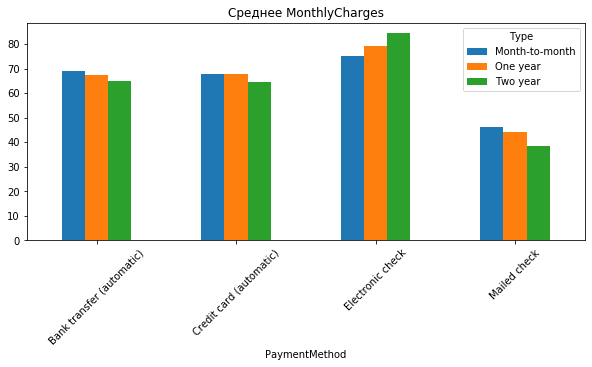

In [70]:
print('Среднее MonthlyCharges по способам оплаты и типу:')
contracts_df.pivot_table(
        index='PaymentMethod', columns='Type', 
        values='MonthlyCharges',
        aggfunc='mean').plot(kind='bar', figsize=(10, 4), 
                             title='Среднее MonthlyCharges')
plt.xticks(rotation=45);

Странно, что соотношение пропорций практическое равное во всех способах оплаты независимо от типа платежа. Однако есть скошенность графика вправо, возможно указывающий на наличие скидки в зависимости от типа платежа

Также посмотрим на среднюю продолжительность договора с клиентов в разрезе способа оплаты и типа платежа. Влияют ли эти переменные на продолжительность

Среднее MonthInDelta по способам оплаты и типу:


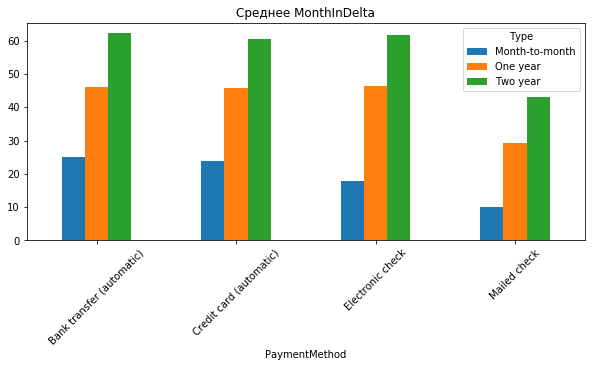

In [71]:
print('Среднее MonthInDelta по способам оплаты и типу:')
contracts_df.pivot_table(
        index='PaymentMethod', columns='Type', 
        values='MonthInDelta',
        aggfunc='mean').plot(kind='bar', figsize=(10, 4), 
                             title='Среднее MonthInDelta')
plt.xticks(rotation=45);

Mailed check снова выделяется. На этот способ приходится самые низкие показатели. Плюс на графике явно видна зависимости, клиенты оплачивающий раз в год или в два года в раз дольше в среднем сидят на договорах. Видимо это связано с тем, что они раз оплатили и впоследствии договор не расторгают. Посмотрим, распределение по кол-ву расторжений в разрезе наших категорий

Кол-во расторжников по способам оплаты и типу:


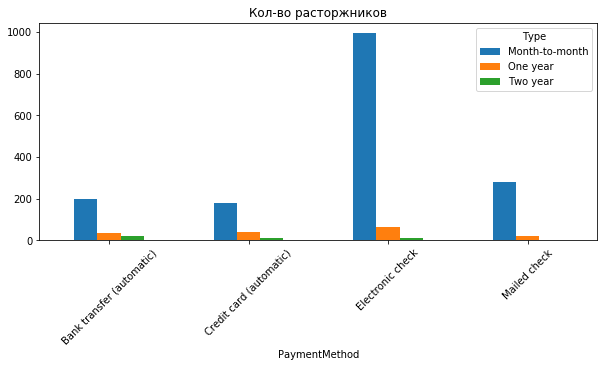

In [72]:
print('Кол-во расторжников по способам оплаты и типу:')
contracts_df[contracts_df['Label'] == 1].pivot_table(
        index='PaymentMethod', columns='Type', 
        values='Label',
        aggfunc='sum').plot(kind='bar', figsize=(10, 4), 
                             title='Кол-во расторжников')
plt.xticks(rotation=45);

График намекает нам о том, что чаще всего расторгаются клиенты на месячных платежах. Плюс ко всему это чаще происходит для клиентов со способами оплаты **Electronic check** и **Mailed check**. Наверно, им просто не нравятся эти способы оплаты

Проверим, как в среднем влияет наша пвсевдо скидка `CheckDicount` на расторжение

Кол-во расторжников по CheckDiscount и типу:


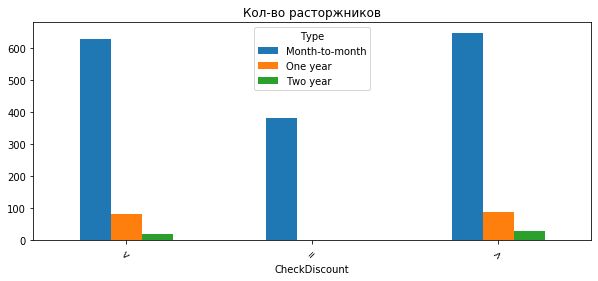

In [73]:
print('Кол-во расторжников по CheckDiscount и типу:')
contracts_df[contracts_df['Label'] == 1].pivot_table(
        index='CheckDiscount', columns='Type', 
        values='Label',
        aggfunc='sum').plot(kind='bar', figsize=(10, 4), 
                             title='Кол-во расторжников')
plt.xticks(rotation=45);

Похоже, что такой зависимости нет. Т.к. кол-во расторжников примерно одинаковое в случаях >, < и соотношений пропорций в раззрезе типов одинаковое. Даже присутствует обратная зависимость, когда кол-во отказников гораздо выше для случаев, когда клиент платит >, < по договору, чем для случаев равенства 

Посмотрим, как псевдо скидка влияет на серднюю продолжительности договора

Среднее MonthInDelta по способам оплаты и типу:


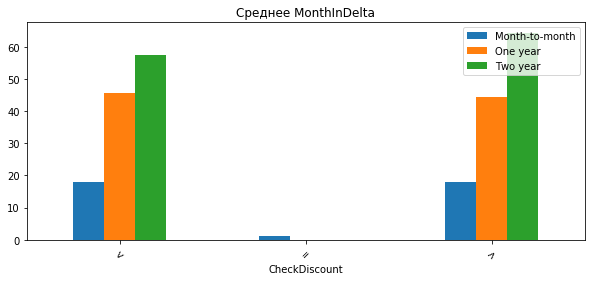

In [74]:
print('Среднее MonthInDelta по способам оплаты и типу:')
contracts_df[contracts_df['Label'] == 1].pivot_table(
        index='CheckDiscount', columns='Type', 
        values='MonthInDelta',
        aggfunc='mean').plot(kind='bar', figsize=(10, 4), 
                             title='Среднее MonthInDelta')
plt.xticks(rotation=45)
plt.legend(loc='upper right');

А тут зависимость всё таки есть, средняя продолжительность договора для случаев >, < гораздо выше случаев = . Т.е. договора, где клиент платить ниже или выше ожидаемой цены живут гораздо дольше, чем при равенстве

Провери, есть ли зависимость расторжения от даты подключения.Выделим год и месяц из даты подключения, сгруппируем и просуммируем таргеты

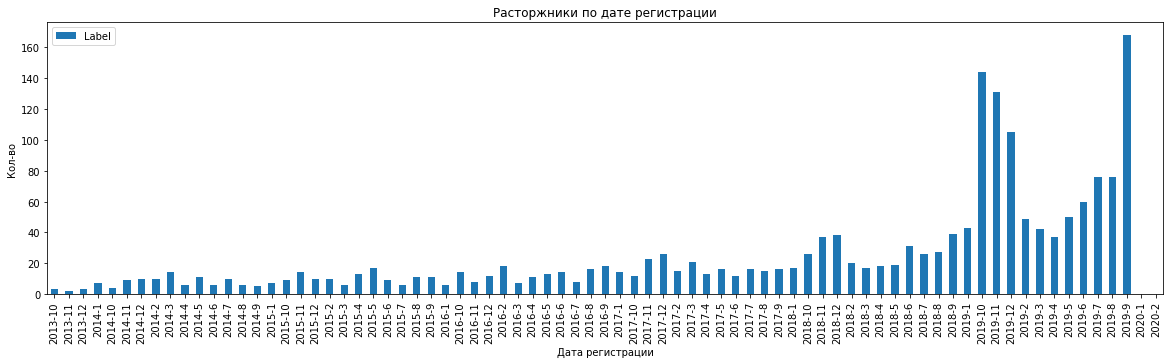

In [75]:
contracts_df['BeginYearMonth'] = contracts_df.index.year.astype('str') + \
'-' + contracts_df.index.month.astype('str')
contracts_df.pivot_table(
    index='BeginYearMonth',
    values='Label',
    aggfunc='sum'
).plot(kind='bar', figsize=(20,5))
plt.title('Расторжники по дате регистрации')
plt.xlabel('Дата регистрации')
plt.ylabel('Кол-во');

Зависимость явно присутствует. На графике видно, что кол-во рассторжников гораздо выше для подключившихся позднее 2018 года. Будем использовать год и месяц подключения в качестве признаков

### Выводы

1. Есть определённые зависимости от способа оплаты и даты регистрации
2. Есть аномалии, требующие внимания владельца задачи, такие как разнящаяся сумма оплаты 

## Обощённый датасет

Посмотрим, есть ли какие-то зависимости от наличия услуги телефонии, интернета или от персональных характеристик клиента по отношению к расторжникам. Проведём анализ на объединённом датасет 

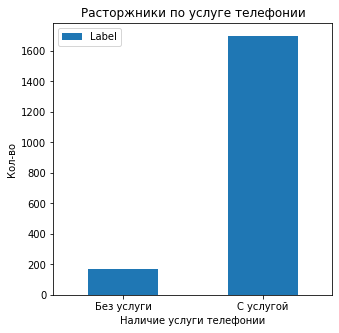

In [76]:
merged_df.pivot_table(
    index='is_active_phone',
    values='Label',
    aggfunc='sum'
).plot(kind='bar', figsize=(5,5))
plt.title('Расторжники по услуге телефонии')
plt.xticks(range(2), labels=[ 'Без услуги', 'С услугой'], rotation=0)
plt.xlabel('Наличие услуги телефонии')
plt.ylabel('Кол-во');

In [77]:
print('Доля рассторжников с телефонией: {:.2%}'.format(
    merged_df.loc[merged_df['is_active_phone'] == 1, 'Label'].sum() / merged_df['Label'].sum())
     )

Доля рассторжников с телефонией: 90.90%


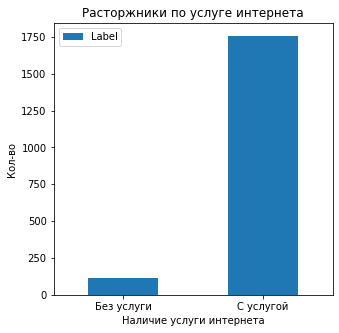

In [78]:
merged_df.pivot_table(
    index='is_active_internet',
    values='Label',
    aggfunc='sum'
).plot(kind='bar', figsize=(5,5))
plt.title('Расторжники по услуге интернета')
plt.xticks(range(2), labels=[ 'Без услуги', 'С услугой'], rotation=0)
plt.xlabel('Наличие услуги интернета')
plt.ylabel('Кол-во');

In [79]:
print('Доля рассторжников с телефонией: {:.2%}'.format(
    merged_df.loc[merged_df['is_active_internet'] == 1, 'Label'].sum() / merged_df['Label'].sum())
     )

Доля рассторжников с телефонией: 93.95%


In [80]:
print('Доля рассторжников с телефонией и интернетом: {:.2%}'.format(
    merged_df.loc[
        ((merged_df['is_active_internet'] == 1) &
        (merged_df['is_active_phone'] == 1)) , 'Label'].sum() / merged_df['Label'].sum())
     )

Доля рассторжников с телефонией и интернетом: 84.86%


Посмотрим, как влияют персональные характеристики клиента на расторжение. Начнём с иждивенцов, влияет ли их наличие на желание расторгнуть договор?

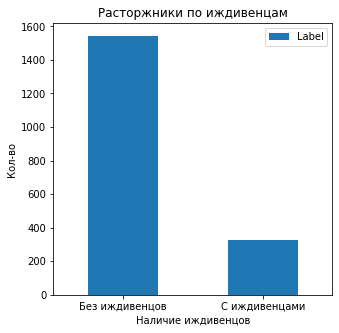

In [81]:
merged_df.pivot_table(
    index='Dependents',
    values='Label',
    aggfunc='sum'
).plot(kind='bar', figsize=(5,5))
plt.title('Расторжники по иждивенцам')
plt.xlabel('Наличие иждивенцов')
plt.xticks(range(2), labels=[ 'Без иждивенцов', 'С иждивенцами'], rotation=0)
plt.ylabel('Кол-во');

Как мы видим наличие иждивенцов влияет не сильно на рассторжение. Скорее клиенты без иждивеноцв более склонны к расторжению

А на сколько часто рассторгаются пенсионеры?

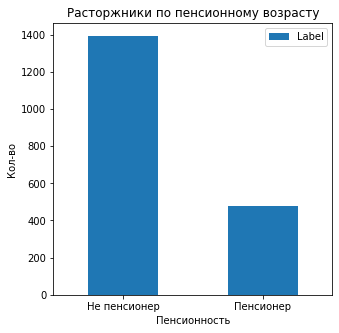

In [82]:
merged_df.pivot_table(
    index='SeniorCitizen',
    values='Label',
    aggfunc='sum'
).plot(kind='bar', figsize=(5,5))
plt.title('Расторжники по пенсионному возрасту')
plt.xlabel('Пенсионность')
plt.xticks(range(2), labels=[ 'Не пенсионер', 'Пенсионер'], rotation=0)
plt.ylabel('Кол-во');

Ну, в общем тоже не сильно влияет. Дальше можно строить ещё много разрезов зависимостей, но мы на этом остановимся и перейдём к моделированию

# Разбивка на train, val, test базового датасета

Подготовим выборки для передачи в модель. Пока будем использовать только контракты. Прежде чем добавлять остальные датасеты проверим, как модель будет себя вести на контрактах

In [83]:
# выделим таргеты в отдельную переменную
targets = contracts_main_features_df['Label']
contracts_main_features_df.drop('Label', axis=1, inplace=True)

Разделим датасет на выборки

In [84]:
#отделим тестовую выборку 
X_train, X_test, y_train, y_test = train_test_split(
    contracts_main_features_df.drop('customerID', axis=1), targets, test_size=.25, random_state=42)
#разобьём трейн на валид
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=.25, random_state=42)

print('Размеры train: признаки {}, таргеты {}'.format(X_train.shape, y_train.shape))
print('Размеры val: признаки {}, таргеты {}'.format(X_val.shape, y_val.shape))
print('Размеры test: признаки {}, таргеты {}'.format(X_test.shape, y_test.shape))

Размеры train: признаки (3961, 15), таргеты (3961,)
Размеры val: признаки (1321, 15), таргеты (1321,)
Размеры test: признаки (1761, 15), таргеты (1761,)


Удостоверимся, что соотношение баланса классов соблюдёно во всех выборках

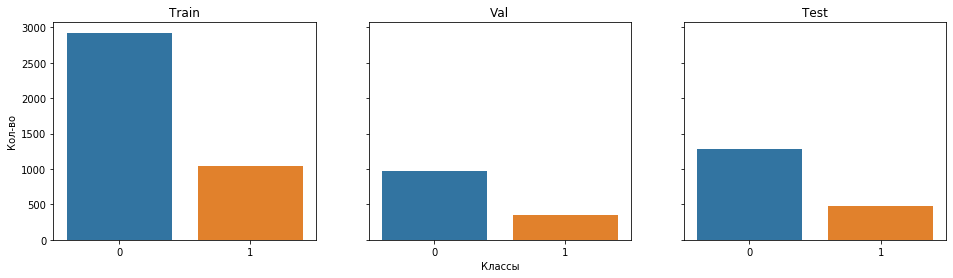

In [85]:
_, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
sns.barplot(y=y_train.value_counts().values, x=y_train.value_counts().index, ax=axes[0])
sns.barplot(y=y_val.value_counts().values, x=y_val.value_counts().index, ax=axes[1])
sns.barplot(y=y_test.value_counts().values, x=y_test.value_counts().index, ax=axes[2])
axes[1].set_xlabel('Классы')
axes[0].set_ylabel('Кол-во')
axes[0].set_title('Train')
axes[1].set_title('Val')
axes[2].set_title('Test');

In [86]:
print('Доля положительных train: {:.2%}'.format(y_train.sum()/y_train.shape[0]))
print('Доля положительных val: {:.2%}'.format(y_val.sum()/y_val.shape[0]))
print('Доля положительных test: {:.2%}'.format(y_test.sum()/y_test.shape[0]))

Доля положительных train: 26.16%
Доля положительных val: 26.80%
Доля положительных test: 27.20%


## Выводы 

1. Произведена разбивка датасета на подвыборки train, val, test 
2. В выборках пока только самые важные признаки из основного датасета контрактов. Если моделям их будет недостаточно, будем добавлять ещё признаков 
3. Форма и баланс классов соблюдены во всех подвыборках 
4. Кол-во положительных классов довольно низкое, для того, чтобы модель могла научиться адекватно его прогнозировать. Возможно придётся применять технику апсемплинга

# Оценка баланса классов

Оценим баланс классов на основе выделенного нами признака `Label`

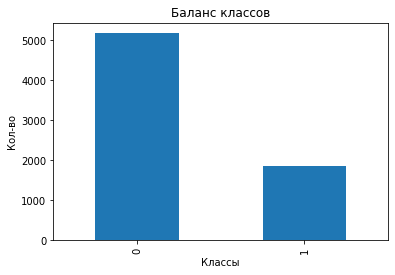

In [87]:
contracts_df['Label'].value_counts().plot(kind='bar')
plt.title('Баланс классов')
plt.xlabel('Классы')
plt.ylabel('Кол-во');

На лицо явный дисбаланс классов. Отрицательных классов (клиенты рассторгнувшие договор) почти в 3 раза меньше, чем положительных классов. Далее прибегнем либо к методу уравнивания классов, либо будем использовать метрики оценки модели, неподдверженные дисбалансу, например precision, recall или ROC AUC.

In [88]:
print('Доля расторжников в датасете: {:.2%}'.format(
    contracts_df['Label'].sum()/contracts_df.shape[0]
))

Доля расторжников в датасете: 26.54%


## Выводы

1. Присутствуюет явный дисбаланс классов 
2. Дисбаланс естественный, т.к. основная масса клиентов расположена пользоваться услугами, а не расторгаться 
3. Доля положительных классов (рассторжников) составляет ~ 26%

# Масштабирование признаков

Модели сильно капризные в плане величины значенйи признаков, поэтому отмасштабируем признаки. Обучать масштабатор будем на трейне, а тест и валид будем трансформировать им же

In [89]:
features_to_scale = ['MonthlyCharges', 'MonthInDelta' , 'IntervalsInEndBeginDeltaByType',  
                     'BeginYear', 'BeginMonth','PayInterval', 'TotalCharges', 'year', 'two_year']

std_scaler = StandardScaler()
std_scaler.fit(X_train[features_to_scale])

scaled_features_train = std_scaler.transform(X_train[features_to_scale])
scaled_features_val = std_scaler.transform(X_val[features_to_scale])
scaled_features_test = std_scaler.transform(X_test[features_to_scale])

X_train_scaled = X_train.drop(['EndBeginDelta'], axis=1).copy()
X_val_scaled = X_val.drop(['EndBeginDelta'], axis=1).copy()
X_test_scaled = X_test.drop(['EndBeginDelta'], axis=1).copy()

X_train_scaled[features_to_scale] = scaled_features_train
X_val_scaled[features_to_scale] = scaled_features_val
X_test_scaled[features_to_scale] = scaled_features_test

# Анализ корреляций

Если раньше большинство признаков имело бинарный вид, то сейчас все наши признаки приобрели вид непрерывных значений. А это даёт нам возможность проанализировать корреляции методом Пирсона. Методом переборанайдём наименее коррелирующие между собой признаки, чтобы модели не учились выискивать их паттерны

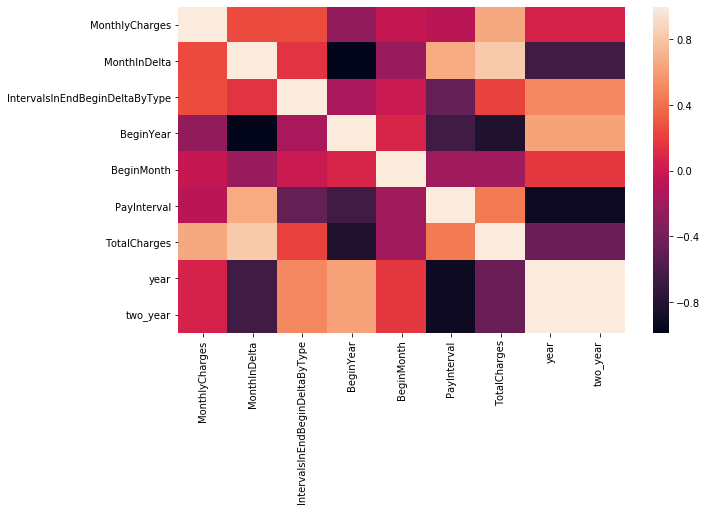

In [90]:
#соберём всё в один фрейм
train = X_train_scaled[features_to_scale]
val = X_val_scaled[features_to_scale]
test = X_test_scaled[features_to_scale]

df = pd.concat([train, val, test], axis=0)
plt.figure(figsize=(10,6))
sns.heatmap(df.corr());

In [91]:
df.corr()

,MonthlyCharges,MonthInDelta,IntervalsInEndBeginDeltaByType,BeginYear,BeginMonth,PayInterval,TotalCharges,year,two_year
MonthlyCharges,1.000000,0.247817,0.255952,-0.264251,-0.018072,-0.074584,0.651182,0.061557,0.061557
MonthInDelta,0.247817,1.000000,0.150212,-0.987092,-0.232236,0.671193,0.826547,-0.651454,-0.651454
IntervalsInEndBeginDeltaByType,0.255952,0.150212,1.000000,-0.161533,-0.006060,-0.470154,0.221388,0.507451,0.507451
BeginYear,-0.264251,-0.987092,-0.161533,1.000000,0.081542,-0.647074,-0.819517,0.631956,0.631956
BeginMonth,-0.018072,-0.232236,-0.006060,0.081542,1.000000,-0.200946,-0.194330,0.170127,0.170127
PayInterval,-0.074584,0.671193,-0.470154,-0.647074,-0.200946,1.000000,0.444994,-0.919518,-0.919518
TotalCharges,0.651182,0.826547,0.221388,-0.819517,-0.194330,0.444994,1.000000,-0.447071,-0.447071
year,0.061557,-0.651454,0.507451,0.631956,0.170127,-0.919518,-0.447071,1.000000,1.000000
two_year,0.061557,-0.651454,0.507451,0.631956,0.170127,-0.919518,-0.447071,1.000000,1.000000


Величиена корреляций признаков соершенно разная. Все виды связей по силе. Есть очень сильные положительные и отрицательные корреляции, например – год регистрации от кол-ва месяцев в дельте между расторжением и началом. По хорошему, один из этих признаков следует удалить, чтобы модель не училась выявлять закономерности основываясь на этой корреляции, но превысить ROC AUC > .88 позволяет только эта связь. Удалив её, максимально, что удаётся достигнуть это ROC AUC .84 

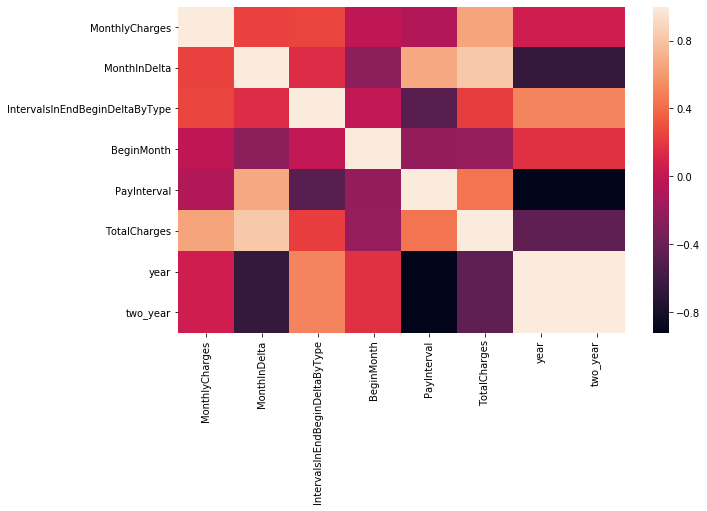

In [92]:
plt.figure(figsize=(10,6))
sns.heatmap(df.drop('BeginYear', axis=1).corr());

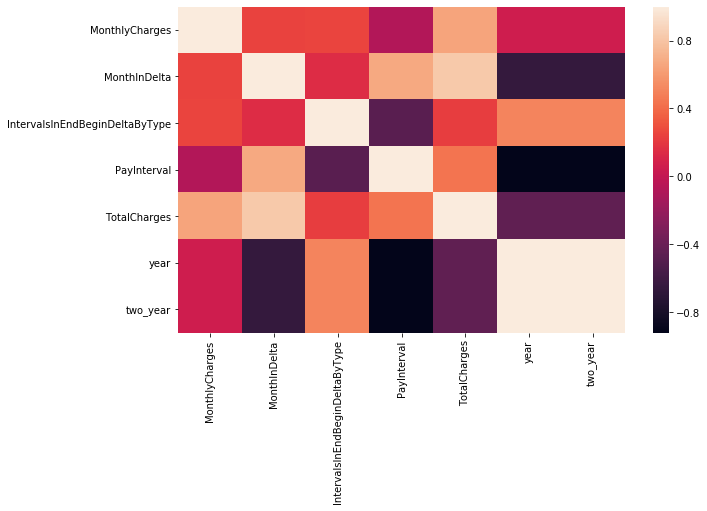

In [93]:
plt.figure(figsize=(10,6))
sns.heatmap(df.drop(['BeginYear', 'BeginMonth'], axis=1).corr());

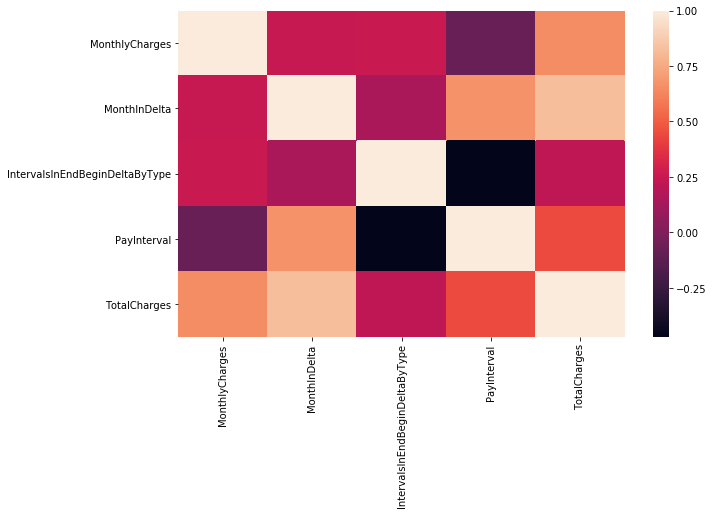

In [94]:
plt.figure(figsize=(10,6))
sns.heatmap(df.drop(['BeginYear', 'year', 'two_year', 'BeginMonth'], axis=1).corr());

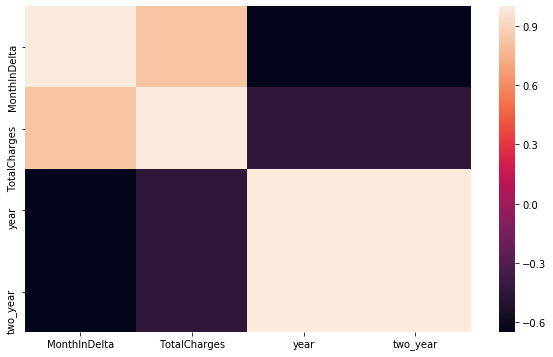

In [95]:
plt.figure(figsize=(10,6))
sns.heatmap(df.drop(['BeginYear', 'IntervalsInEndBeginDeltaByType', 
                     'BeginMonth', 'PayInterval', 'MonthlyCharges'], axis=1).corr());

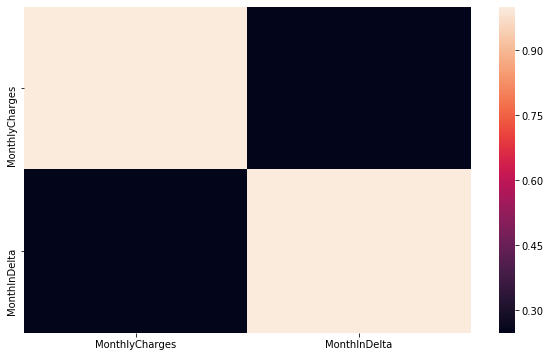

In [96]:
plt.figure(figsize=(10,6))
sns.heatmap(df.drop(['BeginYear', 'IntervalsInEndBeginDeltaByType', 'BeginMonth', 
                     'year', 'two_year','PayInterval', 'TotalCharges'], axis=1).corr());

Не смотря на то, что дельта в месяцах и месячные платежи достаточно сильно между собой коррелируют убирать один из признаков из модели не имеет смысла, т.к. и сумма и срок использования договора имеет определяющее значение. Сумма и качество сервиса напрямую влияет на настроение клиента, если соотношение по цене качество конфликтуют, то и высок риск расторжения. Также и срок использования договора имеет прямое влияние на решение клиента о продолжении договора в случае высокой цены и низкого сервиса, например

Подготовим несколько выборок для тестирования

In [97]:
main_corr_features = ['PaperlessBilling', 'MonthlyCharges', 'MonthInDelta', 'TotalCharges',
       'Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)',
       'PayInterval', 'IntervalsInEndBeginDeltaByType']

low_corr_features = ['PaperlessBilling', 'MonthlyCharges', 'Electronic check', 
                     'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']

Их корреляции 

Корреляции набора признаков main_corr_features


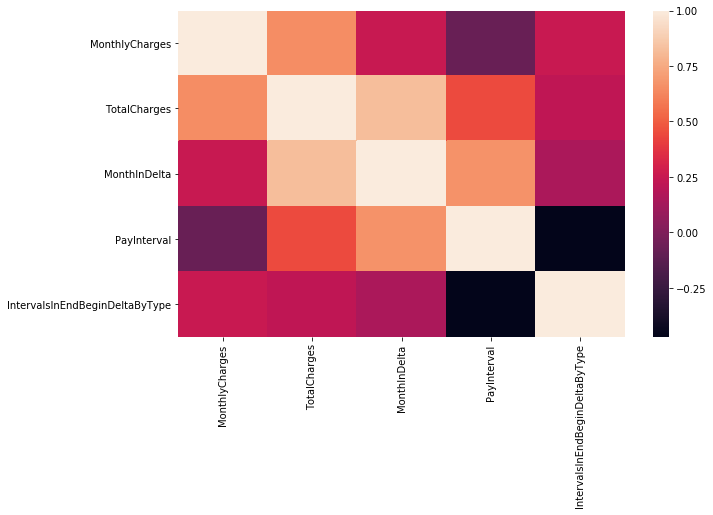

In [98]:
print('Корреляции набора признаков main_corr_features')
plt.figure(figsize=(10,6))
sns.heatmap(df[['MonthlyCharges', 'TotalCharges', 'MonthInDelta',
                'PayInterval', 'IntervalsInEndBeginDeltaByType']].corr());

In [99]:
X_train_scaled_both_features = X_train_scaled[main_corr_features].copy()
X_val_scaled_both_features = X_val_scaled[main_corr_features].copy()
X_test_scaled_both_features = X_test_scaled[main_corr_features].copy()

X_train_scaled_month_char = X_train_scaled[low_corr_features].copy()
X_val_scaled_month_char = X_val_scaled[low_corr_features].copy()
X_test_scaled_month_char = X_test_scaled[low_corr_features].copy()

X_train_scaled_all_features = X_train_scaled.copy()
X_val_scaled_all_features = X_val_scaled.copy()
X_test_scaled_all_features = X_test_scaled.copy()

# Моделирование на базовой выборке

Мы собираемся прогнозировать отток клиентов, для этого нам нужна вероятностная модель, которая на выходе сможет выдавать вероятности классов. Напомним, что мы инвертировали логику и положительным классом сделали рассторжников, а отрицательным классом действующих клиентов. Начнём моделирование с построения базовой дамми модели, а затем перейдём к более продвинутым моделям и сравним их результаты

## Dummy модель

Для начала дамми модель будем строить по стратегии самый часто встречающий класс. Таким образом, модель всегда будет предсказывать 0 класс, означающий, что клиент не желает расторгать договор

In [100]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_scaled, y_train)
preds_dummy = dummy.predict(X_val_scaled)
roc_auc_dummy = roc_auc_score(y_val, preds_dummy)
accuracy_dummy = accuracy_score(y_val, preds_dummy)
print(f'Dummy ROC AUC: {roc_auc_dummy}')
print(f'Dummy accuracy: {accuracy_dummy}')

Dummy ROC AUC: 0.5
Dummy accuracy: 0.7320211960635882


Относительно неплохие результаты точности, а вот ROC AUC 0.5 указывает на то, что модель явно рандомным образом предсказывает класс. Попробуем другой подход, при котором дамми модель будет всегда предсказывать положительный класс, т.е. 1, означающий, что каждый клиент желает рассторгнуться, каике тогда у нас будут показатели?

In [101]:
dummy = DummyClassifier(strategy='constant', constant=1)
dummy.fit(X_train_scaled, y_train)
preds_dummy = dummy.predict(X_val_scaled)
roc_auc_dummy = roc_auc_score(y_val, preds_dummy)
accuracy_dummy = accuracy_score(y_val, preds_dummy)
print(f'Dummy ROC AUC: {roc_auc_dummy}')
print(f'Dummy accuracy: {accuracy_dummy}')

Dummy ROC AUC: 0.5
Dummy accuracy: 0.2679788039364118


ROC AUC всё на том же уровне, а вот точность закономерно упала и остановилась именно на том уровне, который соответствует балансу наших классов

### Выводы

Дамми модель в некоторых случаях может принести достаточно хороший результат, который сложно будет обойти моделям машинного обучения, но не в данном случае. Обе стратегии, показывают низкие результаты ROC AUC, соответствующие  предсказанию случайного класса

## Вероятностные модели

### Логистическая регрессия

#### Главные признаки

In [102]:
model_log_reg = LogisticRegression(n_jobs=-1, class_weight='balanced', solver='lbfgs')
model_log_reg.fit(X_train_scaled_both_features, y_train)
preds_log_reg = model_log_reg.predict(X_val_scaled_both_features)
probs = model_log_reg.predict_proba(X_val_scaled_both_features)

In [103]:
def print_metrics(targets, preds, probs):
    print(f'Accuracy: {accuracy_score(targets, preds)}')
    print(f'ROC AUC: {roc_auc_score(targets, probs)}')
    print('Отчёт по классификации:')
    display(pd.DataFrame(confusion_matrix(targets, preds)))
    print('ROC кривая:')
    fpr, tpr, _ = roc_curve(targets, probs)
    plt.plot(fpr, tpr, label='Предсказание модели')
    plt.plot([0, 1], label='Случайная классификация')
    plt.legend();

Accuracy: 0.712339137017411
ROC AUC: 0.8369790662483422
Отчёт по классификации:


,0,1
0,655,312
1,68,286


ROC кривая:


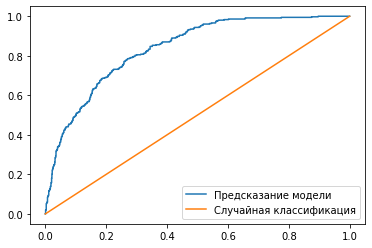

In [104]:
print_metrics(y_val, preds_log_reg, probs[:, 1])

In [105]:
def test_log_reg_model(X_train, y_train, X_val, y_val):
    model_log_reg = LogisticRegression(n_jobs=-1, class_weight='balanced', solver='lbfgs')
    model_log_reg.fit(X_train, y_train)
    preds_log_reg = model_log_reg.predict(X_val)
    probs = model_log_reg.predict_proba(X_val)
    print_metrics(y_val, preds_log_reg, probs[:, 1])

#### Один признак

Accuracy: 0.6707040121120363
ROC AUC: 0.7020927909137118
Отчёт по классификации:


,0,1
0,671,296
1,139,215


ROC кривая:


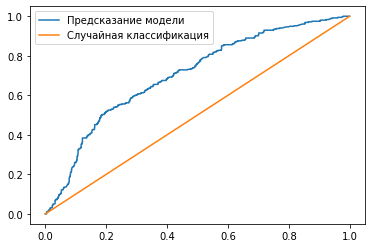

In [106]:
test_log_reg_model(X_train_scaled_month_char, y_train, 
                   X_val_scaled_month_char, y_val)

### Градиентный бустинг деревьев

#### Главные признаки

In [107]:
grid_params = {
    'n_estimators':[100, 250, 500, 600],
    'max_depth':[3, 4, 5],
    'learning_rate':[.2, .4, .6, .8]
}

In [108]:
def grb_grid_search(X_train, y_train, X_val, y_val):

    model_grb = GradientBoostingClassifier()
    grid = GridSearchCV(model_grb, param_grid=grid_params, n_jobs=-1, cv=5)
    grid.fit(X_train, y_train)
    preds = grid.best_estimator_.predict(X_val)
    probs = grid.best_estimator_.predict_proba(X_val)
    print('Лучшие параметры:', grid.best_params_)
    print_metrics(y_val, preds, probs[:, 1])

In [109]:
grb_grid_search(X_train_scaled_both_features, y_train,
               X_val_scaled_both_features, y_val)

По парамтерам мы упёрлись в нижнии границы всех 3-х параметров. Попробуем добавить ещё несколько вариантов параметров и ещё рза прогнать обучение

In [110]:
grid_params = {
    'n_estimators':[25, 50, 100, 250, 500, 600],
    'max_depth':[2, 3, 4, 5],
    'learning_rate':[.001, .01, .1, .2, .4, .6, .8]
}

In [111]:
grb_grid_search(X_train_scaled_both_features, y_train,
               X_val_scaled_both_features, y_val)

#### Один признак

In [112]:
grb_grid_search(X_train_scaled_month_char, y_train,
               X_val_scaled_month_char, y_val)

### Плотная нейросеть

#### Главные признаки

In [113]:
def test_net(X_train, y_train, X_val, y_val):
    model = Sequential()
    model.add(Dense(units=64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=512,  activation='relu'))
    model.add(Dense(units=1024,  activation='relu'))
    model.add(Dense(units=1024,  activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=.001), metrics=['acc', 'AUC'])
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
             epochs=15, verbose=2)

In [114]:
test_net(X_train_scaled_both_features, y_train, 
         X_val_scaled_both_features, y_val)

#### Один признак

In [115]:
test_net(X_train_scaled_month_char, y_train,
         X_val_scaled_month_char, y_val)

### Выводы

1. Лучшее качество модели показывает градиентынй бустинг с парамтерами 
2. Расхождение в качестве модели в зависимости от набора признаков по типу корреляции незначительное
3. Лучшая модель чаще фолснегативит и прогнозирует отрицательный класс для образцов положительного класса. При таком раскладе, вероятна потеря клиента, поэтому имеет место переопредлить порог классификации для модели, чтобы она чаще фолспозитивила, таким образом можно слегка потерять в марже на дискаунтах клиентов, зато сохранить их

# Апсемплинг и даунсемплинг

In [116]:
def upsample(features, target, repeat): 
    features_zeros = features[target == 0] 
    features_ones = features[target == 1] 
    target_zeros = target[target == 0] 
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) 
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle( 
        features_upsampled, target_upsampled, random_state=12345
    )
    
    return features_upsampled, target_upsampled

In [117]:
def downsample(features, target, fraction): 
    features_zeros = features[target == 0] 
    features_ones = features[target == 1] 
    target_zeros = target[target == 0] 
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, 
                                                       target_downsampled, 
                                                       random_state=12345)
    return features_downsampled, target_downsampled

In [118]:
#сбросим индексы, чтобы функция апсемплинга правильно отработала
y_train.reset_index(inplace=True, drop=True)
X_train_scaled_both_features.reset_index(inplace=True, drop=True)
y_val.reset_index(inplace=True, drop=True)
X_val_scaled_both_features.reset_index(inplace=True, drop=True)

y_train.reset_index(inplace=True, drop=True)
X_train_scaled_month_char.reset_index(inplace=True, drop=True)
y_val.reset_index(inplace=True, drop=True)
X_val_scaled_month_char.reset_index(inplace=True, drop=True)

In [119]:
X_train_scaled_upsampled_both, y_train_upsampled = upsample(
    X_train_scaled_both_features, y_train, repeat=3
)
X_train_scaled_downsampled_both, y_train_downsampled = downsample(
    X_train_scaled_both_features, y_train, fraction=.4
)

X_train_scaled_upsampled_one, y_train_upsampled = upsample(
    X_train_scaled_month_char, y_train, repeat=3
)
X_train_scaled_downsampled_one, y_train_downsampled = downsample(
    X_train_scaled_month_char, y_train, fraction=.4
)

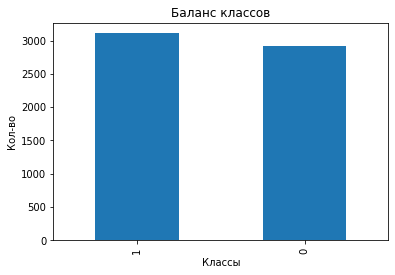

In [120]:
#проверим баланс классов
y_train_upsampled.value_counts().plot(kind='bar')
plt.xlabel('Классы')
plt.title('Баланс классов')
plt.ylabel('Кол-во');

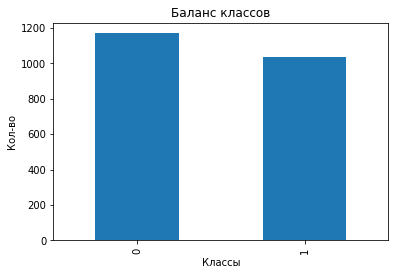

In [121]:
#проверим баланс классов
y_train_downsampled.value_counts().plot(kind='bar')
plt.xlabel('Классы')
plt.title('Баланс классов')
plt.ylabel('Кол-во');

## Выводы 

Мы подготовили дополнительную тренировочную выборку со сбаласнированными классами. Посмотрим, как модели будут вести себя сейчас

# Моделирование на ресемплированных выборках

## Логистическая регрессия

### Главные признаки

#### Апсемлированная выборка

In [122]:
test_log_reg_model(X_train_scaled_upsampled_both, y_train_upsampled, 
                   X_val_scaled_both_features, y_val)

#### Даунсемплированная выборка

In [123]:
test_log_reg_model(X_train_scaled_downsampled_both, y_train_downsampled, 
                   X_val_scaled_both_features, y_val)

### Один признак

#### Апсемлированная выборка 

In [124]:
test_log_reg_model(X_train_scaled_upsampled_one, y_train_upsampled, 
                   X_val_scaled_month_char, y_val)

#### Даунсемплированная выборка

In [125]:
test_log_reg_model(X_train_scaled_downsampled_one, y_train_downsampled, 
                   X_val_scaled_month_char, y_val)

## Градиентный бустинг

#### Апсемплированная выборка

In [126]:
grb_grid_search(X_train_scaled_upsampled_both, y_train_upsampled,
               X_val_scaled_both_features, y_val)

А тут мы упёрлись в верхнюю границую n_estimators. Попробуем добавить ещё несколько вариантов 

In [127]:
grid_params = {
    'n_estimators':[250, 500, 600, 700, 800, 900],
    'max_depth':[2, 3, 4, 5],
    'learning_rate':[.001, .01, .1, .2, .4, .6, .8]
}

In [128]:
grb_grid_search(X_train_scaled_upsampled_both, y_train_upsampled,
               X_val_scaled_both_features, y_val)

#### Даунсемплированная выборка

In [129]:
grb_grid_search(X_train_scaled_downsampled_both, y_train_downsampled,
               X_val_scaled_both_features, y_val)

## Плотная нейросеть

### Апсемлированная выборка 

In [130]:
test_net(X_train_scaled_upsampled_both, y_train_upsampled, 
         X_val_scaled_both_features, y_val)

### Даунсемплированная выборка

In [131]:
test_net(X_train_scaled_downsampled_both, y_train_downsampled, 
        X_val_scaled_both_features, y_val)

## Выводы

Апсемлинг не принёс плодов. Сильного прироста кач-ва не наблюдается. Некоторые модели даже хуже прогнозируют с ресеплированныеми данными

# Присоединение признаков

Настало время посмотреть в сторону добавления дополнительных признаков. Объединим контракты, телефонию и интернет и персональные данные клиентов

In [132]:
contracts_main_features_df.reset_index(inplace=True, drop=True)
phone_concatenated_df.reset_index(inplace=True, drop=True)
internet_concatenated_df.reset_index(inplace=True, drop=True)
personal_df.reset_index(inplace=True, drop=True)

merged_df = contracts_main_features_df.merge(internet_concatenated_df, on='customerID')
merged_df = merged_df.merge(phone_concatenated_df, on='customerID')
merged_df = merged_df.merge(personal_df, left_on='customerID', right_on='customerID')
merged_df.shape

merged_df.drop(['customerID'], axis=1, inplace=True)

# Разбивка на train, val, test объединённого датасета

In [133]:
#отделим тестовую выборку 
X_train, X_test, y_train, y_test = train_test_split(
    merged_df, targets, test_size=.25, random_state=42)
#разобьём трейн на валид
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=.25, random_state=42)

print('Размеры train: признаки {}, таргеты {}'.format(X_train.shape, y_train.shape))
print('Размеры val: признаки {}, таргеты {}'.format(X_val.shape, y_val.shape))
print('Размеры test: признаки {}, таргеты {}'.format(X_test.shape, y_test.shape))

Размеры train: признаки (3961, 32), таргеты (3961,)
Размеры val: признаки (1321, 32), таргеты (1321,)
Размеры test: признаки (1761, 32), таргеты (1761,)


# Масштабирование объединённых признаков

In [134]:
#выберем нужные признаки для масштабирования идропа
features_to_scale = ['MonthlyCharges', 'MonthInDelta' , 'IntervalsInEndBeginDeltaByType',  
                     'PayInterval', 'TotalCharges']
features_to_drop = ['year', 'two_year', 'EndBeginDelta',  'BeginYear',
                    'BeginMonth']

#отмасштабируем признаки
std_scaler = StandardScaler()
std_scaler.fit(X_train[features_to_scale])

scaled_features_train = std_scaler.transform(X_train[features_to_scale])
scaled_features_val = std_scaler.transform(X_val[features_to_scale])
scaled_features_test = std_scaler.transform(X_test[features_to_scale])

X_train_scaled = X_train.drop(features_to_drop, axis=1).copy()
X_val_scaled = X_val.drop(features_to_drop, axis=1).copy()
X_test_scaled = X_test.drop(features_to_drop, axis=1).copy()

X_train_scaled[features_to_scale] = scaled_features_train
X_val_scaled[features_to_scale] = scaled_features_val
X_test_scaled[features_to_scale] = scaled_features_test

# Моделирование на объединённом датасете

## Логистическая регрессия

In [135]:
test_log_reg_model(X_train_scaled, y_train,
                  X_val_scaled, y_val)

## Градиентный бустинг

In [136]:
grb_grid_search(X_train_scaled, y_train,
                X_val_scaled, y_val)

In [137]:
grid_params = {
    'n_estimators':[15, 25, 50, 100, 250, 500, 600],
    'max_depth':[2, 3, 4, 5],
    'learning_rate':[.001, .01, .1, .2, .4, .6, .8]
}

In [138]:
grb_grid_search(X_train_scaled, y_train,
                X_val_scaled, y_val)

## Плотная нейросеть

In [139]:
test_net(X_train_scaled, y_train,
         X_val_scaled, y_val)

## Апсемплирование объединённого датасета

In [140]:
#сбросим индексы, чтобы функция апсемплинга правильно отработала
y_train.reset_index(inplace=True, drop=True)
X_train_scaled.reset_index(inplace=True, drop=True)
y_val.reset_index(inplace=True, drop=True)
X_val_scaled.reset_index(inplace=True, drop=True)

In [141]:
X_train_scaled_upsampled, y_train_upsampled = upsample(
    X_train_scaled, y_train, repeat=3
)

In [142]:
grb_grid_search(X_train_scaled_upsampled, y_train_upsampled,
                X_val_scaled, y_val)

# Тестирование лучшей модели

Accuracy: 0.7978421351504826
ROC AUC: 0.8547472796615415
Отчёт по классификации:


,0,1
0,1200,82
1,274,205


ROC кривая:


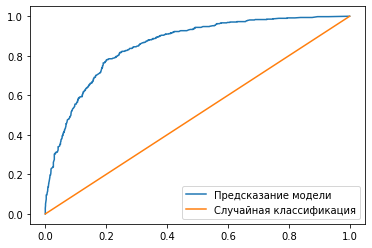

In [143]:
#соберём трейн и вал в датасет
full_train_features = pd.concat([X_train_scaled, X_val_scaled], axis=0)
full_train_labels = pd.concat([y_train, y_val], axis=0)
#переобучим и протестируем
model_grb = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, n_estimators= 25)
model_grb.fit(full_train_features, full_train_labels)
preds = model_grb.predict(X_test_scaled) 
probs = model_grb.predict_proba(X_test_scaled)
print_metrics(y_test, preds, probs[:, 1])

# Конструирование признаков

Попробуем кластеризовать наши данные и добавить дистанцию до ближайшего центра кластера в качестве признака и посмотрим, как это отразится на качестве модели

In [144]:
#подгтовим фрейм 
cluster_df = merged_df.drop(['year',
 'two_year',
 'EndBeginDelta',
 'TotalCharges',
 'BeginYear', 
 'BeginMonth'], axis=1)

In [145]:
#найдём оптимальное кол-во кластеров
from sklearn.cluster import KMeans
distortion = []
K = range(1, 10)
for i in K:
    cluster = KMeans(n_clusters=i)
    cluster.fit(cluster_df)
    distortion.append(cluster.inertia_)
    
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show()

KeyboardInterrupt: 

In [ ]:
#обучим модель кластеризации
cluster = KMeans(n_clusters=5)
cluster.fit(cluster_df)
clusters = cluster.transform(cluster_df)
#добавим расстонияние до ближайшего центра в качестве признака
cluster_df['ClusterDistance'] = clusters.min(axis=1)

In [ ]:
full_train_features = pd.concat([X_train_scaled, X_val_scaled], axis=0)
full_train_labels = pd.concat([y_train, y_val], axis=0)

model = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 3, n_estimators= 500, random_state=42)
model.fit(full_train_features, full_train_labels)
preds = model.predict(X_test_scaled)
probs = model.predict_proba(X_test_scaled)
print_metrics(y_test, preds, probs[:, 1])

In [ ]:
cluster_df

# Разбивка на train, val, test с доп. признаками

In [ ]:
#отделим тестовую выборку 
X_train, X_test, y_train, y_test = train_test_split(
    cluster_df, targets, test_size=.25, random_state=42)
#разобьём трейн на валид
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=.25, random_state=42)

print('Размеры train: признаки {}, таргеты {}'.format(X_train.shape, y_train.shape))
print('Размеры val: признаки {}, таргеты {}'.format(X_val.shape, y_val.shape))
print('Размеры test: признаки {}, таргеты {}'.format(X_test.shape, y_test.shape))

#выберем нужные признаки для масштабирования идропа
features_to_scale = ['MonthlyCharges', 'MonthInDelta' , 'IntervalsInEndBeginDeltaByType',  
                     'PayInterval', 'ClusterDistance']

#отмасштабируем признаки
std_scaler = StandardScaler()
std_scaler.fit(X_train[features_to_scale])

scaled_features_train = std_scaler.transform(X_train[features_to_scale])
scaled_features_val = std_scaler.transform(X_val[features_to_scale])
scaled_features_test = std_scaler.transform(X_test[features_to_scale])

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[features_to_scale] = scaled_features_train
X_val_scaled[features_to_scale] = scaled_features_val
X_test_scaled[features_to_scale] = scaled_features_test

# Моделирование на доп. признаках

# Тестирование модели с доп. признаками

In [ ]:
#протестируем модель
full_train_features = pd.concat([X_train_scaled, X_val_scaled], axis=0)
full_train_labels = pd.concat([y_train, y_val], axis=0)

model = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 3, n_estimators= 600)
model.fit(full_train_features, full_train_labels)
preds = model.predict(X_test_scaled)
probs = model.predict_proba(X_test_scaled)
print_metrics(y_test, preds, probs[:, 1])

## Градиентный бустинг

In [ ]:
model_grb = GradientBoostingClassifier()
model_grb.fit(full_train_features, full_train_labels)
preds = model_grb.predict(X_test_scaled)
probs = model_grb.predict_proba(X_test_scaled)
print_metrics(y_test, preds, probs[:, 1])

# Функция расчёта дискаунта

На базе вероятности положительного класса (т.е. вероятности оттока клиента) мы можем расчитать размер дискаунта. Функция будет принимать в качестве переменных величину вероятности и размер дискаунта при превышении порога вероятности оттока

In [ ]:
def create_discount(charges, proba_value, tresh=.8, discount_value=.15):
    if proba_value > tresh:
        to_pay_charges = charges * (1 - discount_value)
        return discount_value, to_pay_charges
    else:
        to_pay_charges = charges
        return 0, charges

# Общие выводы

1. Качества всех задействованных в исследовании моделей примерно на одном уровне и колеблется в зависимости от мощности корреляции используемых в выборке признаков 0.80 < ROC AUC < 0.97
2. Исходный датасет сильно синтетический с высокими значениями корреляции от даты начала и ограниченным набором возможных значениях (до 5 видов) в дате расторжения 
3. На выходе получаем несколько моделей: 
    1. одна менее заточена под корреляции, т.к. обучается и проверяется на наименее коррелирующих признаках, с макс. ROC AUC = 0.857 (её можно тиражировать не беспокоясь за влияние корреляций), но для достижения выдающегося качества модель либо слабовата, либо признаки в датасете не обладают достаточной репрезентативностью
    2. вторая сильно заточена под корреляцию даты начала (её тиражирование на новых клиентов несёт риск деградации, т.к. модель для всех будущих клиентов просто может не обнаружить тот же шаблон, что она обнаружила на текущих клиентах) с макс. ROC AUC = 0.97 у Логистической регрессии и 0.93 у Градиентного бустинга (если принять во внимание, что Логистическая регрессия более восприимчива к высококоррелированным признакам, то стоит использовать модель градиентного бустинга, т.к. она была менее чувствительна к корреляциям), при этом модели не обязательно передавать все имеющиеся признаки (объединять датасеты), что может существенно оптимизировать скорость обучения и предсказания
4. Ресемплирование, добавление доп. признаков не дают ощутимого прироста качества модели
5. Прогноз оттока выполняется на основе вероятности оттока, где положительный класс в прогнозе модели означает, что клиент собирается рассторгнуться, а расчёт размера дискаунта выполняется на основе превышения вероятности положительного класса определённого порога
6. В данных есть определённые зависимости расторжников от способа оплаты, видимо это играет не последнюю роль в столь высоком качестве модели в совокупности с остальными признаками
7. Также стоит обратить на некоторое несоответствие в исходных данных (например сумма платежей не сходится)

Скорее всего моделям нехватает данных, чтобы показать более высокое качество. Пойдём другим путём, размножим данные. Сделаем это так: 
1. Получим дельту периодов 
2. Посчитаем, сколько раз период встречается за время действия договора клиента 
3. Размножим строки с клиентом на кол-во раз, где в метки запишем 0, для всех строк кроме последней, для которой запишем 1 (только для расторжников, нерасторжников оставим с нулями)

Таким образом получим доп. образцы на каждый период оплаты в интервале и увеличим кол-во образцов

In [ ]:
def multiplicate_rows(row):
    if row['Type'] == 'Month-to-month':
        return row['MonthInDelta']
    elif row['Type'] == 'One year':
        base = row['MonthInDelta'] // 12
        if base != 0:
            return base + (row['MonthInDelta'] // (base * 12))
        else:
            return base
    elif row['Type'] == 'Two year':
        base = row['MonthInDelta'] // 24
        if base != 0:
            return base + (row['MonthInDelta'] // (base * 24))
        else:
            return base

contracts_df['TimeToMulti'] = contracts_df.apply(multiplicate_rows, axis=1)

Код ниже медленный, отрабатывает за 30-40 минут

In [ ]:
contracts_df.reset_index(drop=True, inplace=True)
test = pd.DataFrame(columns=contracts_df.columns)
contracts_df.loc[contracts_df['TimeToMulti'] == 0, 'TimeToMulti'] = 1
rows = []
for row in contracts_df.index:
    n = contracts_df.loc[row, 'TimeToMulti']
    for i in range(n):
        test = test.append(contracts_df.loc[row], ignore_index=True)

In [ ]:
unique_clients = test['customerID'].unique()
for client in unique_clients:
    n = test[test['customerID'] == client].shape[0]
    vals = np.random.randint(0, 1, (1, n))
    
    vals[0, :] = contracts_df.loc[contracts_df['customerID'] == client, 'Label']
    test.loc[test['customerID'] == client, 'Label'] = vals[0, :]

In [ ]:
test['Residuals'] = 0
unique_clients_year = contracts_df.loc[contracts_df['Type'] == 'One year', 'customerID'].unique()
for client in unique_clients_year:
    residuals = (test.loc[test['customerID'] == client, 'MonthInDelta'] - 
    (test.loc[test['customerID'] == client, 'MonthInDelta'] // 12 * 12)).values
    residuals[:-1] = 12
    test.loc[test['customerID'] == client, 'Residuals'] = residuals

In [ ]:
unique_clients_twoyear = contracts_df.loc[contracts_df['Type'] == 'Two year', 'customerID'].unique()
for client in unique_clients_twoyear:
    residuals = (test.loc[test['customerID'] == client, 'MonthInDelta'] - 
    (test.loc[test['customerID'] == client, 'MonthInDelta'] // 24 * 24)).values
    residuals[:-1] = 24
    test.loc[test['customerID'] == client, 'Residuals'] = residuals
    
test.loc[test['Type'] == 'Month-to-month', 'Residuals'] = 1

In [ ]:
#создадим фрейм от копии
multiple_main_features_df = test[[
    'customerID', 'Type', 'PaperlessBilling', 'PaymentMethod',
    'MonthlyCharges',  'Residuals', 'TotalCharges', 'MonthInDelta', 'Label']].copy()

#закодируем категориальные признаки ohe 
ohe_enc = OneHotEncoder()
contracts_cat_feature_ohe = ohe_enc.fit_transform(
    multiple_main_features_df[['PaymentMethod']]
).toarray()


#заполним фрейм ohe признаками
multiple_main_features_df[
    'Electronic check'
] = contracts_cat_feature_ohe[:, 0]

multiple_main_features_df[
   'Mailed check'
] = contracts_cat_feature_ohe[:, 1]

multiple_main_features_df[
    'Bank transfer (automatic)'
] = contracts_cat_feature_ohe[:, 2]

multiple_main_features_df[
    'Credit card (automatic)'
] = contracts_cat_feature_ohe[:, 3]


#удалим дублирующие поля
multiple_main_features_df.drop(['PaymentMethod'], axis=1, inplace=True)

In [ ]:
#добавим 3 новых поля и вычислим значения соотношением месяца к году и к двум годам и обратно
multiple_main_features_df['PayInterval'] = multiple_main_features_df['Type']
multiple_main_features_df['year'] = multiple_main_features_df['Type']
multiple_main_features_df['two_year'] = multiple_main_features_df['Type']

multiple_main_features_df['PayInterval'] = multiple_main_features_df['PayInterval'].apply(lambda x: 
                                                                              1 if x == 'Month-to-month' else (
                                                                              12 if x == 'One year' else 24)
                                                                             )

multiple_main_features_df['year'] = multiple_main_features_df['year'].apply(lambda x: 
                                                                              12 if x == 'Month-to-month' else (
                                                                              1 if x == 'One year' else 1/2)
                                                                             )

multiple_main_features_df['two_year'] = multiple_main_features_df['two_year'].apply(lambda x: 
                                                                              24 if x == 'Month-to-month' else (
                                                                              2 if x == 'One year' else 1)
                                                                             )

In [ ]:
def compare_total_calculated(row):
    '''Сравнивает TotalCharges и рассчитанную CalculatedTotalCharges'''
    return '=' if row['CalculatedTotalCharges'] == row['TotalCharges'] \
            else ('<' if row['CalculatedTotalCharges'] < row['TotalCharges'] else '>')
#получим произведение дельты на месячную плату
multiple_main_features_df['CalculatedTotalCharges'] = multiple_main_features_df['MonthInDelta'] * multiple_main_features_df['MonthlyCharges']
#получим дельту
multiple_main_features_df['CalculatedTotalChargesDelta'] = multiple_main_features_df['CalculatedTotalCharges'] - multiple_main_features_df['TotalCharges']
#применим функцию сравнения тоталов
multiple_main_features_df['CheckDiscount'] = multiple_main_features_df.apply(compare_total_calculated, axis=1)



In [ ]:
ohe_enc = OneHotEncoder()
contracts_cat_feature_ohe = ohe_enc.fit_transform(
    multiple_main_features_df[['Type']]
).toarray()


#заполним фрейм ohe признаками
multiple_main_features_df[
    'Month-to-month'
] = contracts_cat_feature_ohe[:, 0]

multiple_main_features_df[
   'One year'
] = contracts_cat_feature_ohe[:, 1]

multiple_main_features_df[
    'Two year'
] = contracts_cat_feature_ohe[:, 2]


#удалим дублирующие поля
multiple_main_features_df.drop(['Type'], axis=1, inplace=True)

In [ ]:
ohe_enc = OneHotEncoder()
contracts_cat_feature_ohe = ohe_enc.fit_transform(
    multiple_main_features_df[['CheckDiscount']]
).toarray()


#заполним фрейм ohe признаками
multiple_main_features_df[
    '='
] = contracts_cat_feature_ohe[:, 0]

multiple_main_features_df[
   '<'
] = contracts_cat_feature_ohe[:, 1]

multiple_main_features_df[
    '>'
] = contracts_cat_feature_ohe[:, 2]

multiple_main_features_df.drop(['CheckDiscount'], axis=1, inplace=True)

In [ ]:
multiple_main_features_df.reset_index(inplace=True, drop=True)
phone_concatenated_df.reset_index(inplace=True, drop=True)
internet_concatenated_df.reset_index(inplace=True, drop=True)
personal_df.reset_index(inplace=True, drop=True)

multi_merged_df = multiple_main_features_df.merge(internet_concatenated_df, on='customerID')
multi_merged_df = multi_merged_df.merge(phone_concatenated_df, on='customerID')
multi_merged_df = multi_merged_df.merge(personal_df, left_on='customerID', right_on='customerID')
multi_merged_df.shape

multi_merged_df.drop(['customerID'], axis=1, inplace=True)
multi_merged_df

In [ ]:
# multi_merged_df.sort_values(by='customerID', inplace=True)
# multi_merged_df.drop(['customerID'], axis=1, inplace=True)

In [ ]:
#подгтовим фрейм 
cluster_df = multi_merged_df.drop('Label', axis=1)
#найдём оптимальное кол-во кластеров
from sklearn.cluster import KMeans
distortion = []
K = range(1, 10)
for i in K:
    cluster = KMeans(n_clusters=i)
    cluster.fit(cluster_df)
    distortion.append(cluster.inertia_)
    
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show()
#обучим модель кластеризации
cluster = KMeans(n_clusters=5)
cluster.fit(cluster_df)
clusters = cluster.transform(cluster_df)
#добавим расстонияние до ближайшего центра в качестве признака
cluster_df['ClusterDistance'] = clusters.min(axis=1)

Сконструируем доп. признаки

In [ ]:
#расстояние до ближайшего центра кластера (похожие образцы)
multi_merged_df['ClusterDistance'] = clusters.min(axis=1)
multi_merged_df.drop_duplicates(inplace=True)

In [ ]:

targets = multi_merged_df['Label']
# multi_merged_df.drop('Label', axis=1, inplace=True)
multi_merged_df['PaperlessBilling'] = multi_merged_df['PaperlessBilling'].astype('float')
#кол-во интрнет сервисов на клиенте
multi_merged_df['InternetServicesAmount'] =multi_merged_df.loc[: ,['OnlineSecurity', 'OnlineBackup', 
                                                                   'DeviceProtection', 'TechSupport', 
                                                                   'StreamingTV', 'StreamingMovies']].sum(axis=1)
def count_all_services(row):
    if row['is_active_phone'] == 1.0:
        return row['InternetServicesAmount'] + 1
    else:
        return row['InternetServicesAmount']
#общее кол-во сервисов на клиенте
multi_merged_df['ServicesAmount'] = 0
multi_merged_df['ServicesAmount'] = multi_merged_df.apply(count_all_services, axis=1)
        
#присвоим единицу, чтобы при рассчёте средней цены не было деления на ноль

multi_merged_df.loc[multi_merged_df['ServicesAmount'] == 0, 'ServicesAmount'] = 1
#получим среднюю цену на интернет сервисы
multi_merged_df['InternetServicePriceForClient'] = (multi_merged_df['MonthlyCharges'] / 
multi_merged_df['ServicesAmount']) * multi_merged_df['InternetServicesAmount'] 
#получим среднюю цену на телефонию 
multi_merged_df['PhoneServicePriceForClient'] = multi_merged_df['MonthlyCharges'] - ((multi_merged_df['MonthlyCharges'] / 
multi_merged_df['ServicesAmount']) * multi_merged_df['InternetServicesAmount'] )

In [ ]:
#отделим тестовую выборку 
X_train, X_test, y_train, y_test = train_test_split(
    multi_merged_df.drop('Label', axis=1), multi_merged_df['Label'], test_size=.25, random_state=42, shuffle=False)
#разобьём трейн на валид
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=.25, random_state=42, shuffle=False)

print('Размеры train: признаки {}, таргеты {}'.format(X_train.shape, y_train.shape))
print('Размеры val: признаки {}, таргеты {}'.format(X_val.shape, y_val.shape))
print('Размеры test: признаки {}, таргеты {}'.format(X_test.shape, y_test.shape))

#выберем нужные признаки для масштабирования идропа
features_to_scale = ['MonthlyCharges', 'Residuals' ,'TotalCharges', 
                    'PayInterval', 'year', 'two_year', 'MonthInDelta', 
                     'CalculatedTotalCharges', 'PayInterval', 'CalculatedTotalChargesDelta',
                    'ClusterDistance', 'InternetServicesAmount', 'ServicesAmount',
                    'InternetServicePriceForClient', 'PhoneServicePriceForClient']

#отмасштабируем признаки
std_scaler = StandardScaler()
std_scaler.fit(X_train[features_to_scale])

scaled_features_train = std_scaler.transform(X_train[features_to_scale])
scaled_features_val = std_scaler.transform(X_val[features_to_scale])
scaled_features_test = std_scaler.transform(X_test[features_to_scale])

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[features_to_scale] = scaled_features_train
X_val_scaled[features_to_scale] = scaled_features_val
X_test_scaled[features_to_scale] = scaled_features_test

# Качество лучшей модели

In [ ]:
full_train_features = pd.concat([X_train_scaled, X_val_scaled], axis=0)
full_train_labels = pd.concat([y_train, y_val], axis=0)

model = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 3, n_estimators= 600)
model.fit(full_train_features, full_train_labels)
preds = model.predict(X_test_scaled)
probs = model.predict_proba(X_test_scaled)
print_metrics(y_test, preds, probs[:, 1])

In [ ]:
feature_importance = pd.DataFrame(model.feature_importances_, index=full_train_features.columns)
feature_importance.sort_values(by=0, ascending=True, inplace=True)
feature_importance.plot(kind='barh', figsize=(8,8));

Самым важным признаком, по мнению модели ялвяется интервал оплаты, далее идут срок деййствия договора в месяцах и опция DSL. Это достаточно интересно, что модель обращает сильное внмиание на это. Месячная стоимость оплаты тоже играет немаловажную роль

In [ ]:
model = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 3, n_estimators= 550)
model.fit(full_train_features[feature_importance['SeniorCitizen':].index], full_train_labels)
preds = model.predict(X_test_scaled[feature_importance['SeniorCitizen':].index])
probs = model.predict_proba(X_test_scaled[feature_importance['SeniorCitizen':].index])
print_metrics(y_test, preds, probs[:, 1])

In [155]:
contracts_main_features_df['PayInterval'] = contracts_main_features_df['PayInterval'] * 30

In [163]:
contracts_main_features_days_df = contracts_main_features_df[['customerID','PaperlessBilling', 'PayInterval',
                                                             'MonthlyCharges', 'EndBeginDelta', 
                                                             'Electronic check', 'Mailed check',
                                                             'Bank transfer (automatic)', 'Credit card (automatic)',
                                                             'PayInterval']]

In [164]:
contracts_main_features_days_df.reset_index(inplace=True, drop=True)
phone_concatenated_df.reset_index(inplace=True, drop=True)
internet_concatenated_df.reset_index(inplace=True, drop=True)
personal_df.reset_index(inplace=True, drop=True)

merged_df = contracts_main_features_days_df.merge(internet_concatenated_df, on='customerID')
merged_df = merged_df.merge(phone_concatenated_df, on='customerID')
merged_df = merged_df.merge(personal_df, left_on='customerID', right_on='customerID')
merged_df.shape

merged_df.drop(['customerID'], axis=1, inplace=True)

In [165]:
#отделим тестовую выборку 
X_train, X_test, y_train, y_test = train_test_split(
    merged_df, contracts_main_features['Label'], test_size=.25, random_state=42, shuffle=False)
#разобьём трейн на валид
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=.25, random_state=42, shuffle=False)

print('Размеры train: признаки {}, таргеты {}'.format(X_train.shape, y_train.shape))
print('Размеры val: признаки {}, таргеты {}'.format(X_val.shape, y_val.shape))
print('Размеры test: признаки {}, таргеты {}'.format(X_test.shape, y_test.shape))

#выберем нужные признаки для масштабирования идропа
features_to_scale = ['PayInterval', 'MonthlyCharges', 'EndBeginDelta']

#отмасштабируем признаки
std_scaler = StandardScaler()
std_scaler.fit(X_train[features_to_scale])

scaled_features_train = std_scaler.transform(X_train[features_to_scale])
scaled_features_val = std_scaler.transform(X_val[features_to_scale])
scaled_features_test = std_scaler.transform(X_test[features_to_scale])

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[features_to_scale] = scaled_features_train
X_val_scaled[features_to_scale] = scaled_features_val
X_test_scaled[features_to_scale] = scaled_features_test

Размеры train: признаки (3961, 26), таргеты (3961,)
Размеры val: признаки (1321, 26), таргеты (1321,)
Размеры test: признаки (1761, 26), таргеты (1761,)


Accuracy: 0.8347529812606473
ROC AUC: 0.8864777786015686
Отчёт по классификации:


,0,1
0,1196,78
1,213,274


ROC кривая:


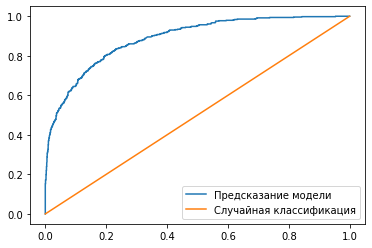

In [171]:
full_train_features = pd.concat([X_train_scaled, X_val_scaled], axis=0)
full_train_labels = pd.concat([y_train, y_val], axis=0)

model = GradientBoostingClassifier(random_state=42)
model.fit(full_train_features, full_train_labels)
preds = model.predict(X_test_scaled)
probs = model.predict_proba(X_test_scaled)
print_metrics(y_test, preds, probs[:, 1])

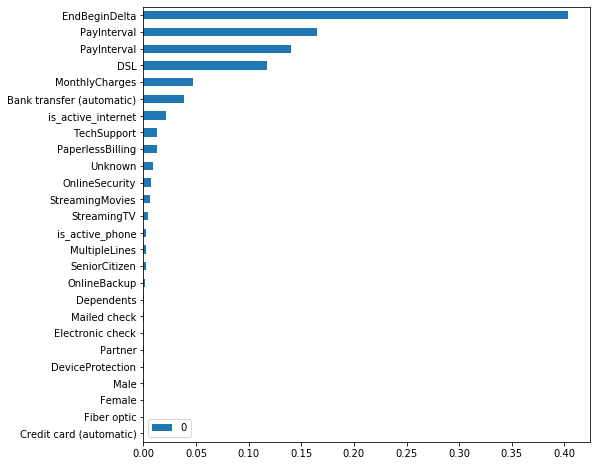

In [170]:
feature_importance = pd.DataFrame(model.feature_importances_, index=full_train_features.columns)
feature_importance.sort_values(by=0, ascending=True, inplace=True)
feature_importance.plot(kind='barh', figsize=(8,8));